In [333]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator
from lib.analysis.cell_roi import RandomROISample, OverlapCounterROI

In [310]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/current_NBQX_theta/10-23-24/"
nbqx_export_summary = data_dir + "export_summary_backup.csv"

camera_program = 4
um_per_px = 6.0 #um

In [311]:
# load CSV of all L4 and L2/3 crossing with NBQX blockade (array only CSV)
crossing_data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
crossing_data = pd.read_csv(crossing_data_dir + 'export_summary_crossing_PPR_array_only.csv')

def read_array_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=None,
                                 names=['Index',  'Values'])
    return np.array(data_arr['Values']).reshape((80, 80))

crossing_data

Layer  drug        Date  Slice  Location  Recording  \
0     L4  ACSF   12/9/2024      2         1          1   
1     L4  NBQX   12/9/2024      2         3          3   
2     L4  ACSF  10/29/2024      1         1          3   
3     L4  NBQX  10/29/2024      1         2          1   
4   L2/3  ACSF  10/23/2024      1         2          3   
5   L2/3  NBQX  10/23/2024      1         2          4   
6   L2/3  ACSF   6/26/2024      1         1          1   
7   L2/3  NBQX   6/26/2024      1         1          4   
8   L2/3  ACSF    7/1/2024      3         2          1   
9   L2/3  NBQX    7/1/2024      3         2          5   
10  L2/3  ACSF    7/1/2024      4         1          1   
11  L2/3  NBQX    7/1/2024      4         1          4   
12  L2/3  ACSF   7/15/2024      2         1          1   
13  L2/3  NBQX   7/15/2024      2         1          5   
14    L4  ACSF   7/17/2024      3         1          1   
15    L4  NBQX   7/17/2024      3         1          5   
16    L4  ACSF  12/11/2024      2         1          1   
17    L4  NBQX  12/11/2024      2         3          2   
18    L4  ACSF  12/11/2024      3         2          1   
19    L4  NBQX  12/11/2024      3         4          2   
20    L4  ACSF  12/18/2024      2         1          2   
21    L4  NBQX  12/18/2024      2         3          1   
22  L2/3  ACSF  12/20/2024      1         3          1   
23  L2/3  NBQX  12/20/2024      1         3          2   

                                            amp_array  \
0   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
1   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
5   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
6   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
7   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
8   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
9   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
10  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
11  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
12  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
13  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
14  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
15  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
16  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
17  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
18  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
19  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
20  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
21  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
22  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
23  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   

                                             ROI file  \
0   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
1   C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
2   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
3   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
4   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
5   C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...   
6   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
7   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
8   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
9   C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
10  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
11  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
12  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
13  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
14  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
15  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
16  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
17  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
18  C:/Users/jjudge3/Desktop/Data/crossing_

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-09-24/converted_zda/_2_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-09-24/converted_zda/_2_3_1_snr_array_.dat


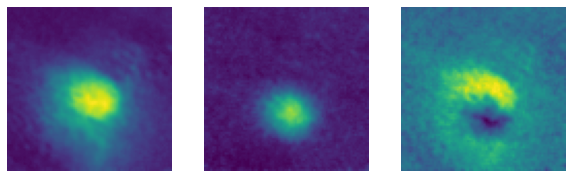

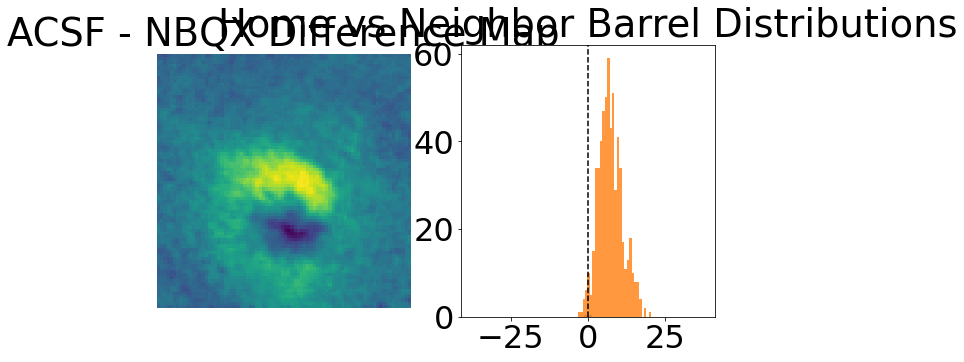

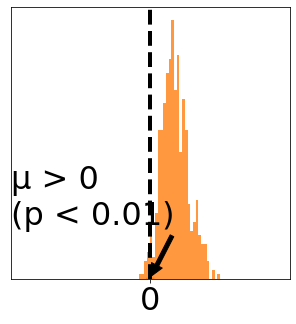

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-29-24\selected_zda/_1_1_3_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-29-24\selected_zda/_1_2_1_snr_array_.dat


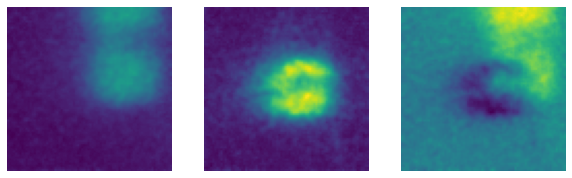

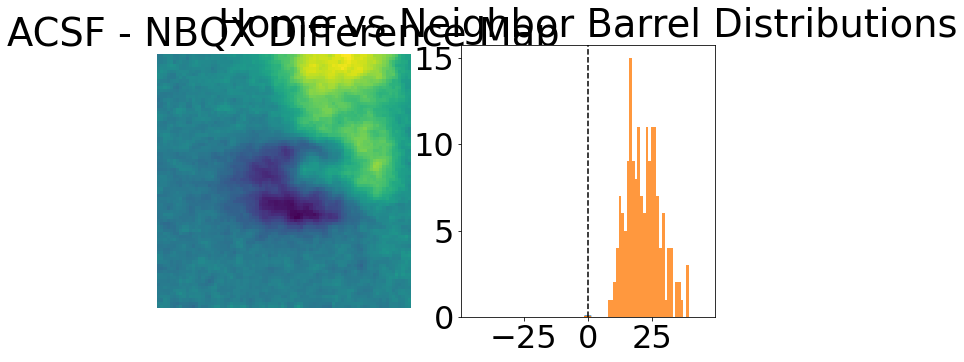

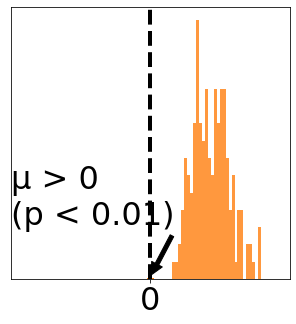

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-17-24/_3_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-17-24/_3_1_5_snr_array_.dat


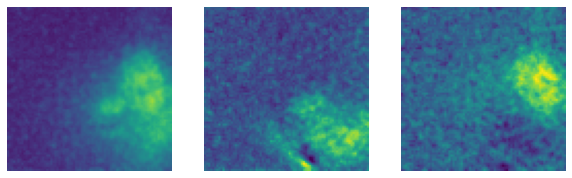

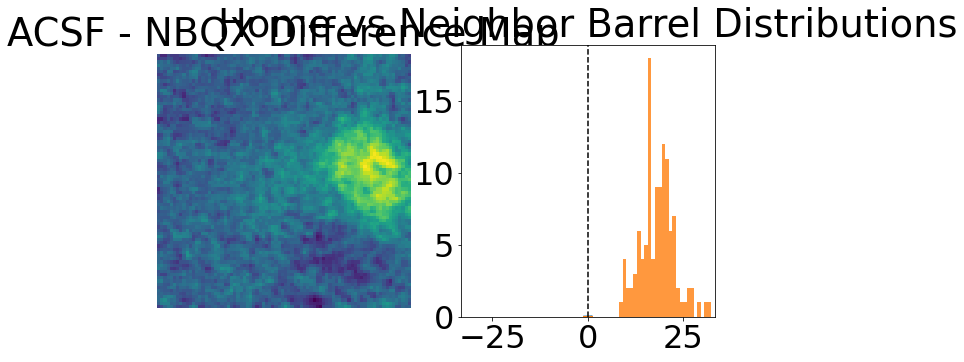

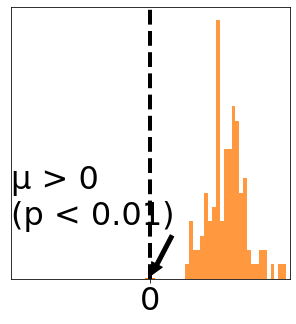

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_2_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_2_3_2_snr_array_.dat


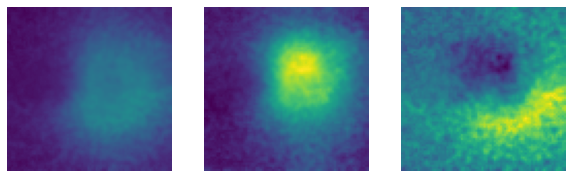

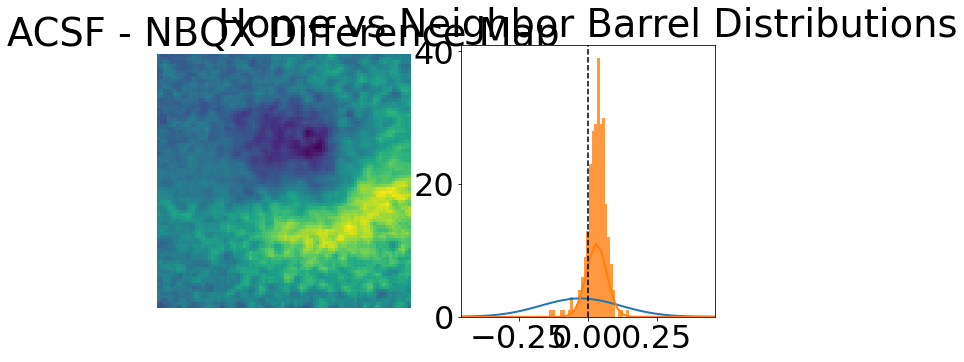

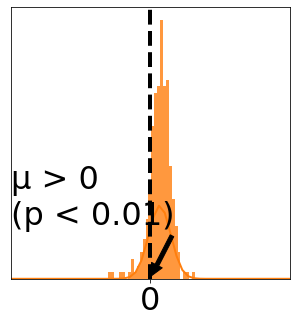

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_3_2_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX/12-11-24/selected_zda/_3_4_2_snr_array_.dat


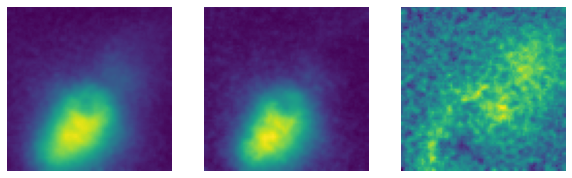

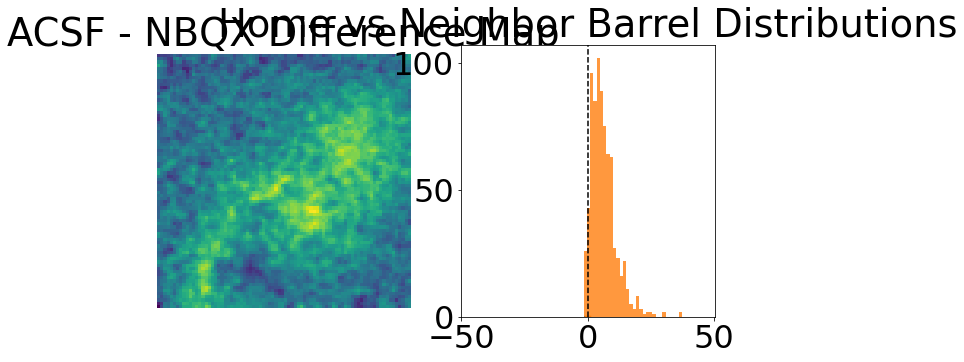

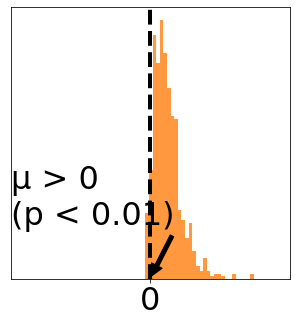

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-18-24/selected_zda/_2_1_2_snr_array_2_rois.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-18-24/selected_zda/_2_3_1_snr_array_2_rois.dat


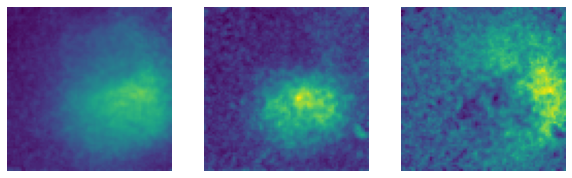

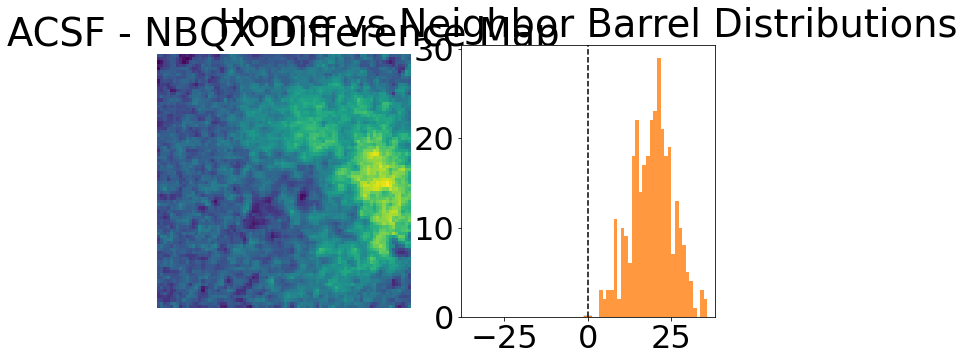

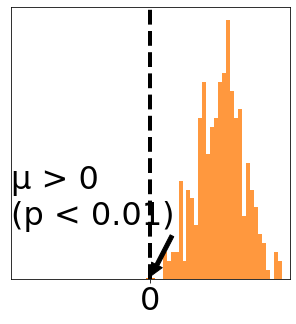

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-23-24\selected_zda/_1_2_3_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/10-23-24\selected_zda/_1_2_4_snr_array_.dat


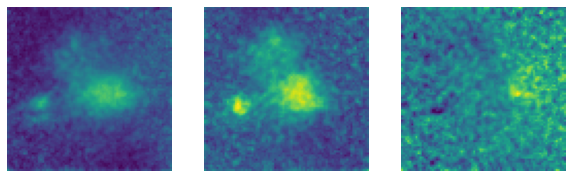

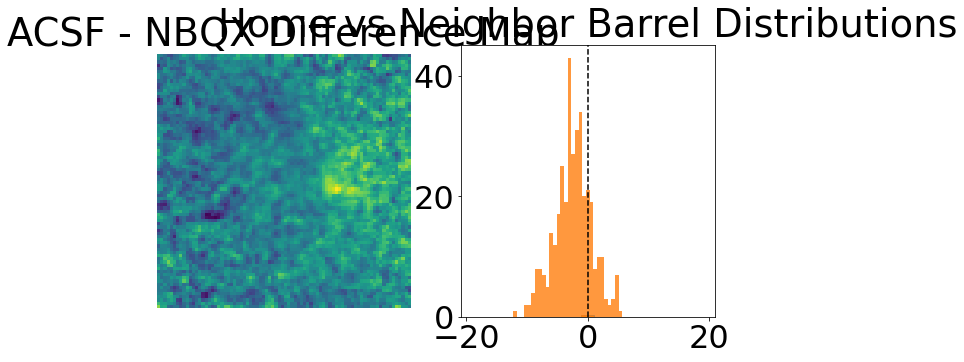

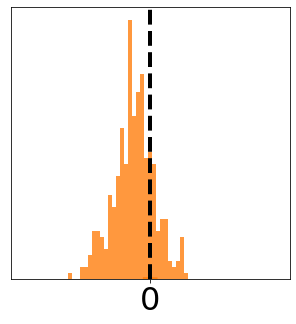

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/06-26-24/_1_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/06-26-24/_1_1_4_snr_array_.dat


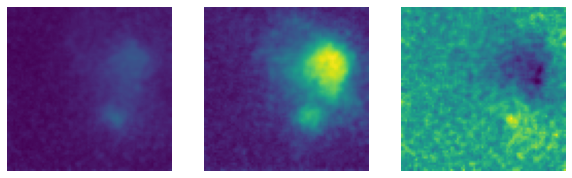

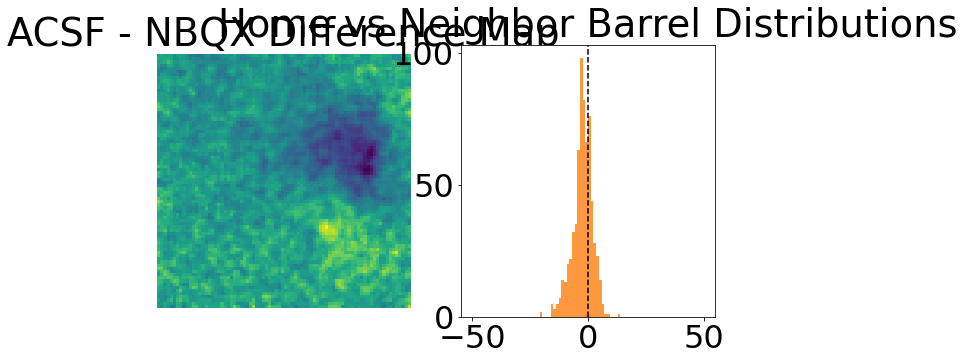

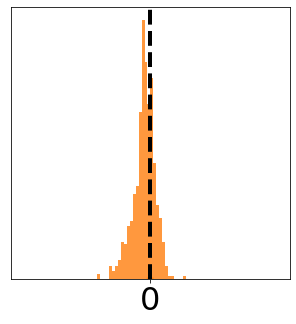

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_3_2_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_3_2_5_snr_array_.dat


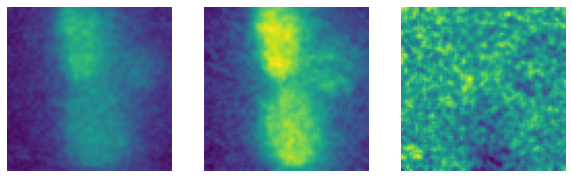

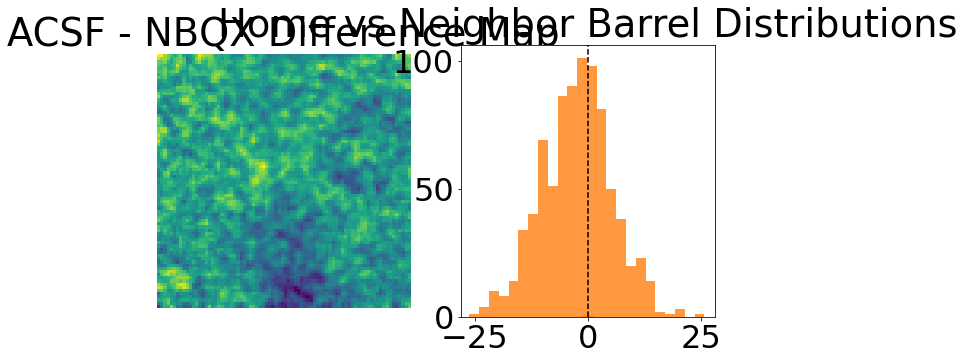

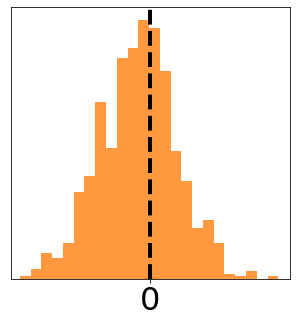

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_4_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-01-24/_4_1_4_snr_array_.dat


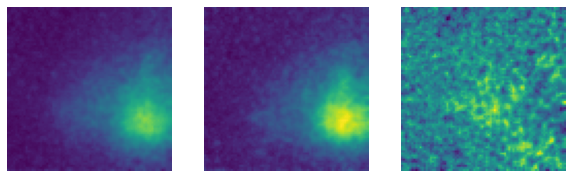

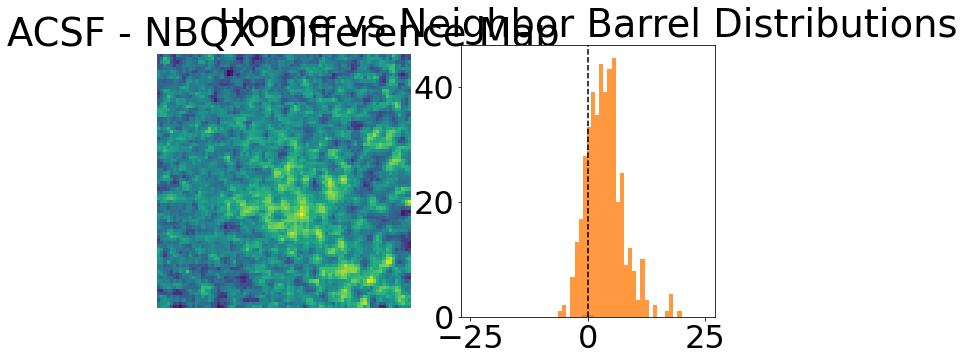

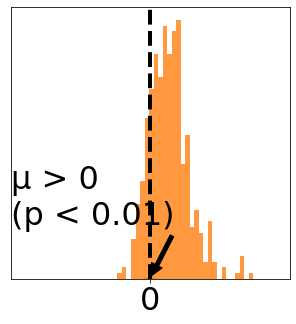

C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-15-24/_2_1_1_snr_array_.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/AnnaW-blockade/selected_for_crossing/07-15-24/_2_1_5_snr_array_.dat


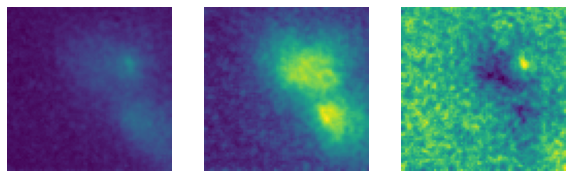

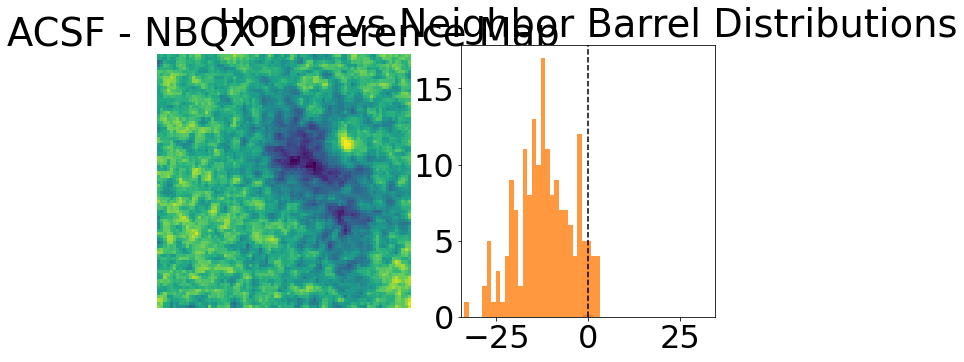

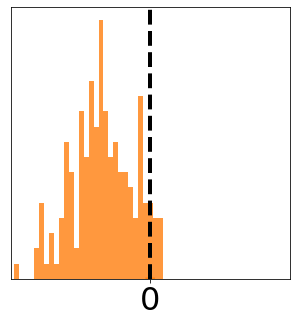

C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-20-24/converted_zda/_1_3_1_snr_array_1_rois.dat
C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/L4_NBQX_2/12-20-24/converted_zda/_1_3_2_snr_array_1_rois.dat


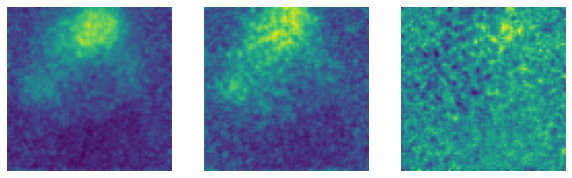

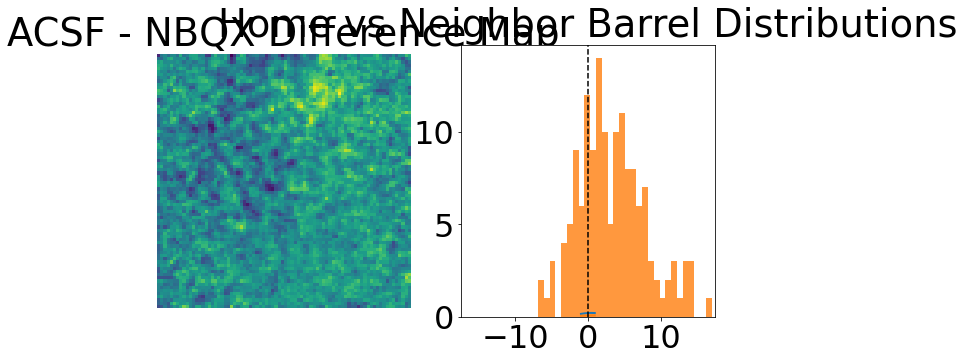

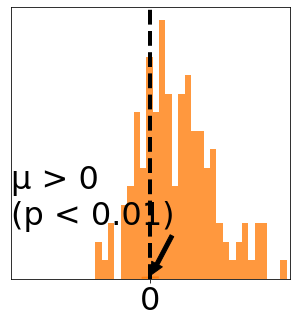

In [312]:
# set matplotlib font size
plt.rcParams.update({'font.size': 32})

# load the array files for each cell
survival_percentile = 70
surviving_pixels = {'L4': {'home': [], 'neighbor': []}, 
                    'L2/3': {'home': [], 'neighbor': []}}
before_pixels = {'L4': {'home': [], 'neighbor': []},
                    'L2/3': {'home': [], 'neighbor': []}}
delta_mins = {'L4': [], 'L2/3': []}
delta_maxs = {'L4': [], 'L2/3': []}
delta_mins_by_barrel = {'L4': {'home': [], 'neighbor': []},
                    'L2/3': {'home': [], 'neighbor': []}}
delta_maxs_by_barrel = {'L4': {'home': [], 'neighbor': []},
                    'L2/3': {'home': [], 'neighbor': []}}
for layer in crossing_data['Layer'].unique():
    layer_df = crossing_data[crossing_data['Layer'] == layer]
    for date in layer_df['Date'].unique():
        date_df = layer_df[layer_df['Date'] == date]
        for slic in date_df['Slice'].unique():
            slic_df = date_df[date_df['Slice'] == slic]

            fig, ax = plt.subplots(1, 3, figsize=(10, 5))
            amp_arrays = {}
            snr_arrays = {}
            amp_arrays_no_norm = {}

            # normalize each pair of arrays to the same scale
            pair_arrays = {}
            for drug in slic_df['drug'].unique():
                drug_df = slic_df[slic_df['drug'] == drug]
                amp_array = drug_df['amp_array'].values[0]
                snr_array = drug_df['snr_array'].values[0]
                amp_array_no_norm = amp_array[:-4] + 'no_norm.dat'

                amp_array = read_array_file(amp_array)
                i_drug = 0 if drug == 'ACSF' else 1
                amp_arrays[drug] = amp_array

                print(snr_array)
                snr_array = read_array_file(snr_array)
                amp_array_no_norm = read_array_file(amp_array_no_norm)
                amp_arrays_no_norm[drug] = amp_array_no_norm

                snr_arrays[drug] = snr_array
                pair_arrays[i_drug] = amp_array_no_norm

            pair_min = min([np.min(arr) for arr in pair_arrays.values()])
            pair_max = max([np.max(arr) for arr in pair_arrays.values()])
            for i_d, arr in enumerate(pair_arrays.values()):
                ax[i_d].imshow(arr, vmin=pair_min, vmax=pair_max)

            # get the difference between the two arrays
            diff_array = amp_arrays['ACSF'] - amp_arrays['NBQX']
            diff_snr_array = snr_arrays['ACSF'] - snr_arrays['NBQX']
            diff_array_no_norm = amp_arrays_no_norm['ACSF'] - amp_arrays_no_norm['NBQX']
            ax[2].imshow(diff_array)
            #ax[1].set_title(layer + '   ' + date + '    Slice ' + str(slic))

            # turn off spines
            for a in ax:
                a.axis('off')

            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_arrays.png')
            plt.show()

            # roi file loading
            roi_file = slic_df['ROI file'].values[0]

            # read in the ROI file
            rois = ROIFileReader(roi_file).get_roi_list()

            # convert from diode to pixel
            rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in rois]

            # first roi is home barrel, rest are neighboring barrels
            home_barrel = rois[0]
            neighbor_barrels = rois[1:]

            # get the survival_percentile% percentile of the ACSF array
            acsf_survive = np.percentile(amp_arrays['ACSF'], survival_percentile)

            # how much of the NBQX array is above the survival_percentile of the ACSF array
            nbqx_above_acsf = amp_arrays['NBQX'] > acsf_survive
            acsf_before = amp_arrays['ACSF'] > acsf_survive
            
            # count the number of pixels above the 95th percentile of the ACSF array in the home barrel
            home_ct = 0
            home_ct_control = 0
            for point in home_barrel:
                x, y = point
                home_ct += nbqx_above_acsf[y, x]
                home_ct_control += acsf_before[y, x]
            surviving_pixels[layer]['home'].append(home_ct)
            before_pixels[layer]['home'].append(home_ct_control)

            # count the number of pixels above the 95th percentile of the ACSF array in the neighbor barrels
            neighbor_ct = 0
            neighbor_ct_control = 0
            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neighbor_ct += nbqx_above_acsf[y, x]
                    neighbor_ct_control += acsf_before[y, x]
            surviving_pixels[layer]['neighbor'].append(neighbor_ct)
            before_pixels[layer]['neighbor'].append(neighbor_ct_control)

            # build the ACSF -> NBQX percent change map
            percent_change_map = np.zeros_like(amp_arrays['ACSF'])
            percent_change_map[amp_arrays['ACSF'] > 0] = (amp_arrays['NBQX'][amp_arrays['ACSF'] > 0] 
                    - amp_arrays['ACSF'][amp_arrays['ACSF'] > 0]) / amp_arrays['ACSF'][amp_arrays['ACSF'] > 0]

            home_barrel_distribution = []
            neighbor_barrel_distribution = []

            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neighbor_barrel_distribution.append(diff_snr_array[y, x])

            for point in home_barrel:
                x, y = point
                home_barrel_distribution.append(diff_snr_array[y, x])

            # fit a normal distribution to the home barrel and neighbor barrel distributions
            home_barrel_distribution = np.array(home_barrel_distribution)
            neighbor_barrel_distribution = np.array(neighbor_barrel_distribution)
            home_mean, home_std = norm.fit(home_barrel_distribution)
            neighbor_mean, neighbor_std = norm.fit(neighbor_barrel_distribution)

            # plot ratio map and home/neighbor barrel distributions
            fig, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(diff_array)
            ax[0].set_title('ACSF - NBQX Difference Map')
            ax[0].axis('off')
            #ax[1].hist(home_barrel_distribution, bins=30, alpha=0.8, label='Home Barrel')
            ax[1].hist(neighbor_barrel_distribution, bins=30, alpha=0.8, label='Neighbor Barrel', color='tab:orange')

            # set the x-axis limits to min-max of histogram
            hist_max = max(-min(home_mean - 3 * home_std, neighbor_mean - 3 * neighbor_std), 
                            max(home_mean + 3 * home_std, neighbor_mean + 3 * neighbor_std))
            #hist_max = 50
            ax[1].set_xlim(-hist_max, hist_max)

            # plot the normal distributions
            x = np.linspace(-0.95, 0.95, 100)
            y_home = norm.pdf(x, home_mean, home_std)
            y_neighbor = norm.pdf(x, neighbor_mean, neighbor_std)
            ax[1].plot(x, y_home, 'tab:blue', linewidth=2)
            ax[1].plot(x, y_neighbor, 'tab:orange', linewidth=2)
            #ax[1].set_xlim(-0.95, 0.95)

            # vertical black line at 0
            ax[1].axvline(x=0, color='black', linestyle='--')

            ax[1].set_title('Home vs Neighbor Barrel Distributions')
            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_distributions.png')
            plt.show()

            # make a separate plot of just the neighbor histogram with no spines
            fig, ax = plt.subplots(1, 1, figsize=(5, 5))
            ax.hist(neighbor_barrel_distribution, bins=30, alpha=0.8, label='Neighbor Barrel', color='tab:orange')
            ax.plot(x, y_neighbor, 'tab:orange', linewidth=2)
            ax.set_xlim(-hist_max, hist_max)
            ax.axvline(x=0, color='black', linestyle='--', linewidth=4)

            # significance testing: is the neighbor barrel distribution less than a distibution with mean 0?
            t, p = ttest_ind(neighbor_barrel_distribution, 
                            np.random.normal(loc=0, scale=np.std(neighbor_barrel_distribution), size=len(neighbor_barrel_distribution)),
                            equal_var=True,
                            alternative='greater')
            if p < 0.01:
                # annotate the p-value as a star above the distribution mean
                ax.annotate('µ > 0 \n(p < 0.01)', xy=(0, 0.1), xytext=(0, 0.2), textcoords='axes fraction',
                                arrowprops=dict(facecolor='black', shrink=0.05))

            ax.set_xticks([0])
            ax.set_yticks([])
            plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + layer.replace("/", "-") + '_' + date.replace('/','-') + '_Slice' + str(slic) + '_neighbor_distribution.png')
            plt.show()

            # save the absolute mins and maxs of the difference map
            delta_mins[layer].append(np.min(diff_array_no_norm))
            delta_maxs[layer].append(np.max(diff_array_no_norm))

            # save the mins and maxs of the difference map by barrel
            neigh_min = np.Inf
            neigh_max = -np.Inf
            for roi in neighbor_barrels:
                for point in roi:
                    x, y = point
                    neigh_min = min(neigh_min, diff_array_no_norm[y, x])
                    neigh_max = max(neigh_max, diff_array_no_norm[y, x])

            home_min = np.Inf
            home_max = -np.Inf
            for point in home_barrel:
                x, y = point
                home_min = min(home_min, diff_array_no_norm[y, x])
                home_max = max(home_max, diff_array_no_norm[y, x])

            delta_mins_by_barrel[layer]['home'].append(home_min)
            delta_maxs_by_barrel[layer]['home'].append(home_max)
            delta_mins_by_barrel[layer]['neighbor'].append(neigh_min)
            delta_maxs_by_barrel[layer]['neighbor'].append(neigh_max)

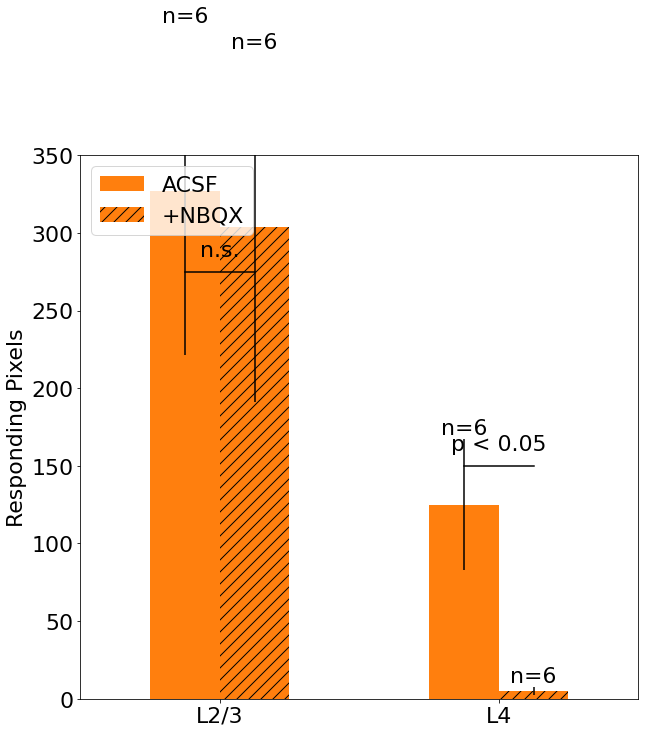

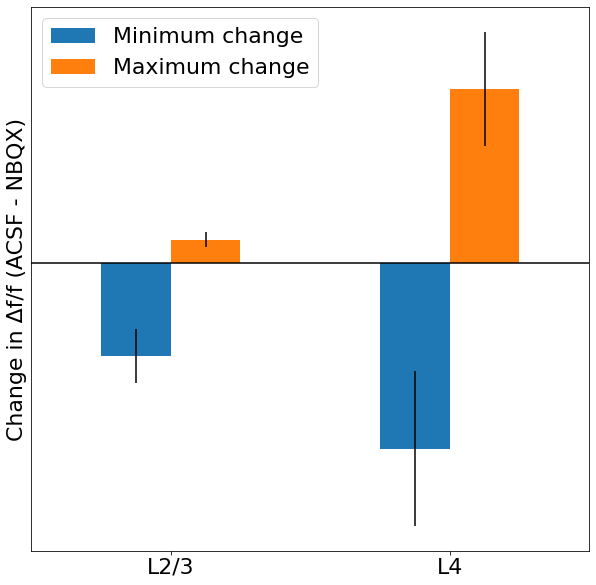

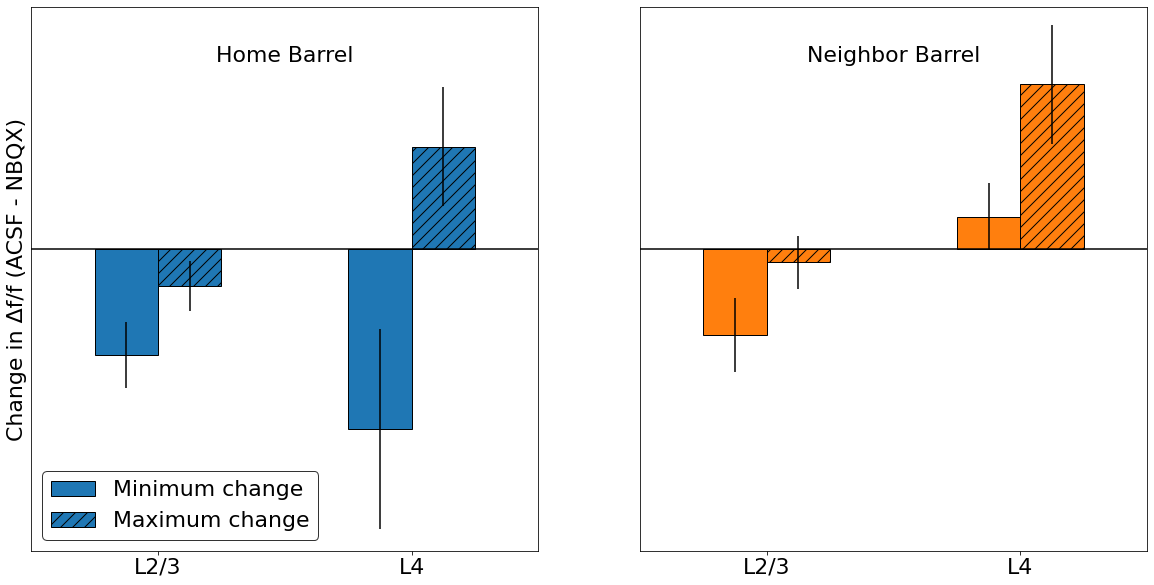

In [313]:
# set matplotlib font size
plt.rcParams.update({'font.size': 22})

# bar plot of surviving pixels, L2/3 vs L4, with error bars
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
layers = ['L2/3', 'L4']

surviving_pixels_mean = [np.mean(surviving_pixels[layer]['home']) for layer in layers]
surviving_pixels_sem = [sem(surviving_pixels[layer]['home']) for layer in layers]
#ax.bar([-.125, .875], surviving_pixels_mean, yerr=surviving_pixels_sem, width=.25, label='Home Barrel')

before_pixels_mean = [np.mean(before_pixels[layer]['neighbor']) for layer in layers]
before_pixels_sem = [sem(before_pixels[layer]['neighbor']) for layer in layers]
ax.bar([-.125, .875], before_pixels_mean, yerr=before_pixels_sem, width=.25, label='ACSF', color='tab:orange')

surviving_pixels_mean = [np.mean(surviving_pixels[layer]['neighbor']) for layer in layers]
surviving_pixels_sem = [sem(surviving_pixels[layer]['neighbor']) for layer in layers]
ax.bar([.125, 1.125], surviving_pixels_mean, yerr=surviving_pixels_sem, width=.25, label='+NBQX', hatch='//', color='tab:orange')
ax.set_ylabel('Responding Pixels')

ax.set_xticks([0, 1])
ax.set_xticklabels(layers)
ax.set_xlim(-.5, 1.5)

# annotate sample size on each layer/drug bar
bar_locs = [-.125, .125, .875, 1.125]
for i, layer in enumerate(layers):
    for j, drug in enumerate(['ACSF', 'NBQX']):
        if drug == 'ACSF':
            drug_dict = before_pixels
        else:
            drug_dict = surviving_pixels

        ax.text(bar_locs[i*2 + j], np.mean(drug_dict[layer]['neighbor']) + sem(drug_dict[layer]['neighbor']) + 3, 
                'n=' + str(len(drug_dict[layer]['neighbor'])), ha='center')

bar_height = [275, 150]
# significance testing: ACSF vs NBQX
for i, layer in enumerate(layers):
    t_stat, p_val = ttest_ind(before_pixels[layer]['neighbor'], surviving_pixels[layer]['neighbor'])
    if p_val < 0.05:
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'p < 0.05', ha='center')

        # add line between home and neighbor barrel
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
    else:
        # add n.s. bar
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'n.s.', ha='center')

'''for i, layer in enumerate(layers):
    for j, barrel in enumerate(['home', 'neighbor']):
        ax.text(bar_locs[i*2 + j], np.mean(surviving_pixels[layer][barrel]) + sem(surviving_pixels[layer][barrel]) + 3, 
                'n=' + str(len(surviving_pixels[layer][barrel])), ha='center')

bar_height = [355, 390]
# significance testing: home vs neighbor barrel
for i, layer in enumerate(layers):
    t_stat, p_val = ttest_ind(surviving_pixels[layer]['home'], surviving_pixels[layer]['neighbor'])
    if p_val < 0.01:
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'p < 0.05', ha='center')

        # add line between home and neighbor barrel
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
    else:
        # add n.s. bar
        ax.plot([bar_locs[i*2], bar_locs[i*2 + 1]], [bar_height[i], bar_height[i]], color='black')
        ax.text((bar_locs[i*2] + bar_locs[i*2 + 1]) / 2, bar_height[i]+10, 'n.s.', ha='center')'''
        
# legend in top left
ax.set_ylim(0, 350)
ax.legend(loc='upper left')
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/surviving_pixels.png')
plt.show()

####### bar plot of absolute mins and maxs of the difference map ############
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
layers = ['L2/3', 'L4']
delta_min_mean = [np.mean(delta_mins[layer]) for layer in layers]
delta_min_sem = [sem(delta_mins[layer]) for layer in layers]
ax.bar([-.125, .875], delta_min_mean, yerr=delta_min_sem, width=.25, label='Minimum change')

delta_max_mean = [np.mean(delta_maxs[layer]) for layer in layers]
delta_max_sem = [sem(delta_maxs[layer]) for layer in layers]
ax.bar([.125, 1.125], delta_max_mean, yerr=delta_max_sem, width=.25, label='Maximum change')

ax.set_ylabel('Change in Δf/f (ACSF - NBQX)') 
ax.set_xticks([0, 1])
ax.set_xticklabels(layers)
ax.set_xlim(-.5, 1.5)
ax.set_yticks([])

# horizontal line at 0
ax.axhline(y=0, color='black')

# save and show the plot
ax.legend(loc='upper left')
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/delta_min_max.png')
plt.show()


####### bar plot of absolute mins and maxs of the difference map by barrel ############
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
layers = ['L2/3', 'L4']

# home barrel in the left plot
delta_min_mean = [np.mean(delta_mins_by_barrel[layer]['home']) for layer in layers]
delta_min_sem = [sem(delta_mins_by_barrel[layer]['home']) for layer in layers]
ax[0].bar([-.125, .875], delta_min_mean, yerr=delta_min_sem, width=.25, label='Minimum change', edgecolor='black', color='tab:blue')

delta_max_mean = [np.mean(delta_maxs_by_barrel[layer]['home']) for layer in layers]
delta_max_sem = [sem(delta_maxs_by_barrel[layer]['home']) for layer in layers]
ax[0].bar([.125, 1.125], delta_max_mean, yerr=delta_max_sem, width=.25, label='Maximum change', edgecolor='black', color='tab:blue', hatch='//')

ax[0].set_ylabel('Change in Δf/f (ACSF - NBQX)')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(layers)
ax[0].set_xlim(-.5, 1.5)

# horizontal line at 0
ax[0].axhline(y=0, color='black')

# neighbor barrel in the right plot
delta_min_mean = [np.mean(delta_mins_by_barrel[layer]['neighbor']) for layer in layers]
delta_min_sem = [sem(delta_mins_by_barrel[layer]['neighbor']) for layer in layers]
ax[1].bar([-.125, .875], delta_min_mean, yerr=delta_min_sem, width=.25, label='Minimum change', edgecolor='black', color='tab:orange')

delta_max_mean = [np.mean(delta_maxs_by_barrel[layer]['neighbor']) for layer in layers]
delta_max_sem = [sem(delta_maxs_by_barrel[layer]['neighbor']) for layer in layers]
ax[1].bar([.125, 1.125], delta_max_mean, yerr=delta_max_sem, width=.25, label='Maximum change', edgecolor='black', color='tab:orange', hatch='//')

ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(layers)
ax[1].set_xlim(-.5, 1.5)

# horizontal line at 0
ax[1].axhline(y=0, color='black')

# annotate left as home and right as neighbor within the plot
ax[0].text(0.5, 0.9, 'Home Barrel', ha='center', transform=ax[0].transAxes)
ax[1].text(0.5, 0.9, 'Neighbor Barrel', ha='center', transform=ax[1].transAxes)

# set left and right plots to share the same y-scale. Pull current y-axis limits and set the same for both plots
y_min = min(ax[0].get_ylim()[0], ax[1].get_ylim()[0])
y_max = max(ax[0].get_ylim()[1], ax[1].get_ylim()[1])
ax[0].set_ylim(y_min, y_max)
ax[1].set_ylim(y_min, y_max)

ax[0].set_yticks([])
ax[1].set_yticks([])

ax[0].legend(loc='lower left', labelcolor='black', facecolor='white', edgecolor='black')

# save and show the plot
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/delta_min_max_by_barrel.png')
plt.show()

In [314]:
# read in hw/lat/amp data
data_dir = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/'
hw_lat_data = data_dir + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6
hw_lat_df

Layer  drug  ROI        amp       snr  latency  halfwidth   X_Center  \
0     L4  ACSF    1   1.208980  44.28930   1.1323    8.08166  50.551020   
1     L4  ACSF    2   0.330953   6.90515   3.4924   26.12920  66.867374   
2     L4  NBQX    1   1.774300  75.77820   1.2188    4.78006  50.551020   
3     L4  NBQX    2   0.325975   7.08423   2.3590    5.69864  66.867374   
4     L4  ACSF    1   1.488840  68.13480   1.6920    6.25805  55.466877   
5     L4  ACSF    2   0.983708  39.26490   4.9494   12.78330  29.060606   
6     L4  NBQX    1   0.000000   0.00000      NaN    6.25805  55.466877   
7     L4  NBQX    2   0.053680   1.00786   5.2739    2.54030  29.060606   
8     L4  ACSF    1  14.255900  56.77760   1.5938    8.15259  40.464912   
9     L4  ACSF    2   3.041910  23.21550   2.3892   15.21730  51.851974   
10    L4  NBQX    1  11.732800  54.59800   2.8157    8.20410  40.464912   
11    L4  NBQX    2   0.701709   3.20418   3.4493   12.61820  51.851974   
12    L4  ACSF    1   2.573440  97.43780   1.3351    6.30031  50.146259   
13    L4  ACSF    2   0.571037  24.28420   2.9283   14.31090  16.678689   
14    L4  NBQX    1   5.443460  77.75390   1.2248    5.51101  50.146259   
15    L4  NBQX    2   0.861818  25.36420   2.4844    6.10551  16.678689   
16    L4  ACSF    1  19.962100  63.10510   2.3035    8.88925  35.790254   
17    L4  ACSF    2   4.861120  53.08610   3.3611   14.41060  59.607509   
18    L4  NBQX    1  18.841000  96.41500   2.4930    7.88870  35.790254   
19    L4  NBQX    2   2.310180  17.46460   2.7515    8.32071  59.607509   
20    L4  ACSF    1  11.198100  87.57760   2.7940        NaN  51.000000   
21    L4  ACSF    2  12.553400  70.35970   2.0402    7.41857  52.287425   
22    L4  NBQX    1  21.239600  65.33420   2.2896    5.21123  51.000000   
23    L4  NBQX    2   3.796700  13.19490   3.1772    7.53653  52.287425   
24  L2/3  ACSF    1   0.546602  28.83120   3.4849   14.78900  46.531977   
25  L2/3  ACSF    2   0.332892  14.80070   3.8840   10.12840  34.393939   
26  L2/3  NBQX    1   0.676087  29.28670   3.5807    4.39530  46.531977   
27  L2/3  NBQX    2   0.508976  29.92430   4.0253    5.33224  34.393939   
28  L2/3  ACSF    1   1.073720  53.76460   3.1838    5.87219        NaN   
29  L2/3  ACSF    2   0.466662  21.17600   3.8387   16.13250        NaN   
30  L2/3  NBQX    2   1.085010  36.89220   4.1900    5.42142        NaN   
31  L2/3  NBQX    1   3.538080  64.96840   3.5978    4.69792        NaN   
32  L2/3  ACSF    1   6.150710  67.93360   2.7378    6.30723        NaN   
33  L2/3  ACSF    2   5.971970  60.32280   3.6349    7.91301        NaN   
34  L2/3  NBQX    1   8.453990  53.83170   2.5830    4.99195        NaN   
35  L2/3  NBQX    2   8.319750  76.03030   3.5719    4.91658        NaN   
36  L2/3  ACSF    1  12.771800  87.66710   2.7700    5.98509        NaN   
37  L2/3  ACSF    2   5.016220  31.97000   3.7273   13.69360        NaN   
38  L2/3  NBQX    1  15.506900  84.73370   2.8276    5.29504        NaN   
39  L2/3  NBQX    2   4.799370  22.44080   3.8786    9.76893        NaN   
40  L2/3  ACSF    1   3.171290  39.36250   1.3686    9.03713        NaN   
41  L2/3  ACSF    2   3.885410  50.35280   2.7901   11.62340        NaN   
42  L2/3  NBQX    1   9.305170  84.64130   1.1554    5.67852        NaN   
43  L2/3  NBQX    2   9.700130  80.91630   2.5481    5.03678        NaN   
44    L4  ACSF    1   7.436220  40.48660   2.9353   10.16720        NaN   
45    L4  ACSF    2   8.699790  42.83210   3.0089    6.29783        NaN   
46    L4  NBQX    1   8.619740  27.99020   3.2368    7.90942        NaN   
47    L4  NBQX    2   2.355590   5.54932   5.6297    8.40421        NaN   
48    L4  ACSF    1   2.658410  40.94130   2.4280   12.50470  53.414035   
49    L4  ACSF    2   1.531480  56.84930   3.8833   14.67710  45.696319   
50    L4  NBQX    1   2.797270  27.63270   2.9883    6.19402  53.414035   
51    L4  NBQX    2   0.695155   5.94485   3.5891    6.02117  45.696319   
52  L2/3  ACSF    1   1.6681

c:\Users\jjudge3\AppData\Local\anaconda3\envs\TSM-to-ZDA\lib\site-packages\numpy\core\_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


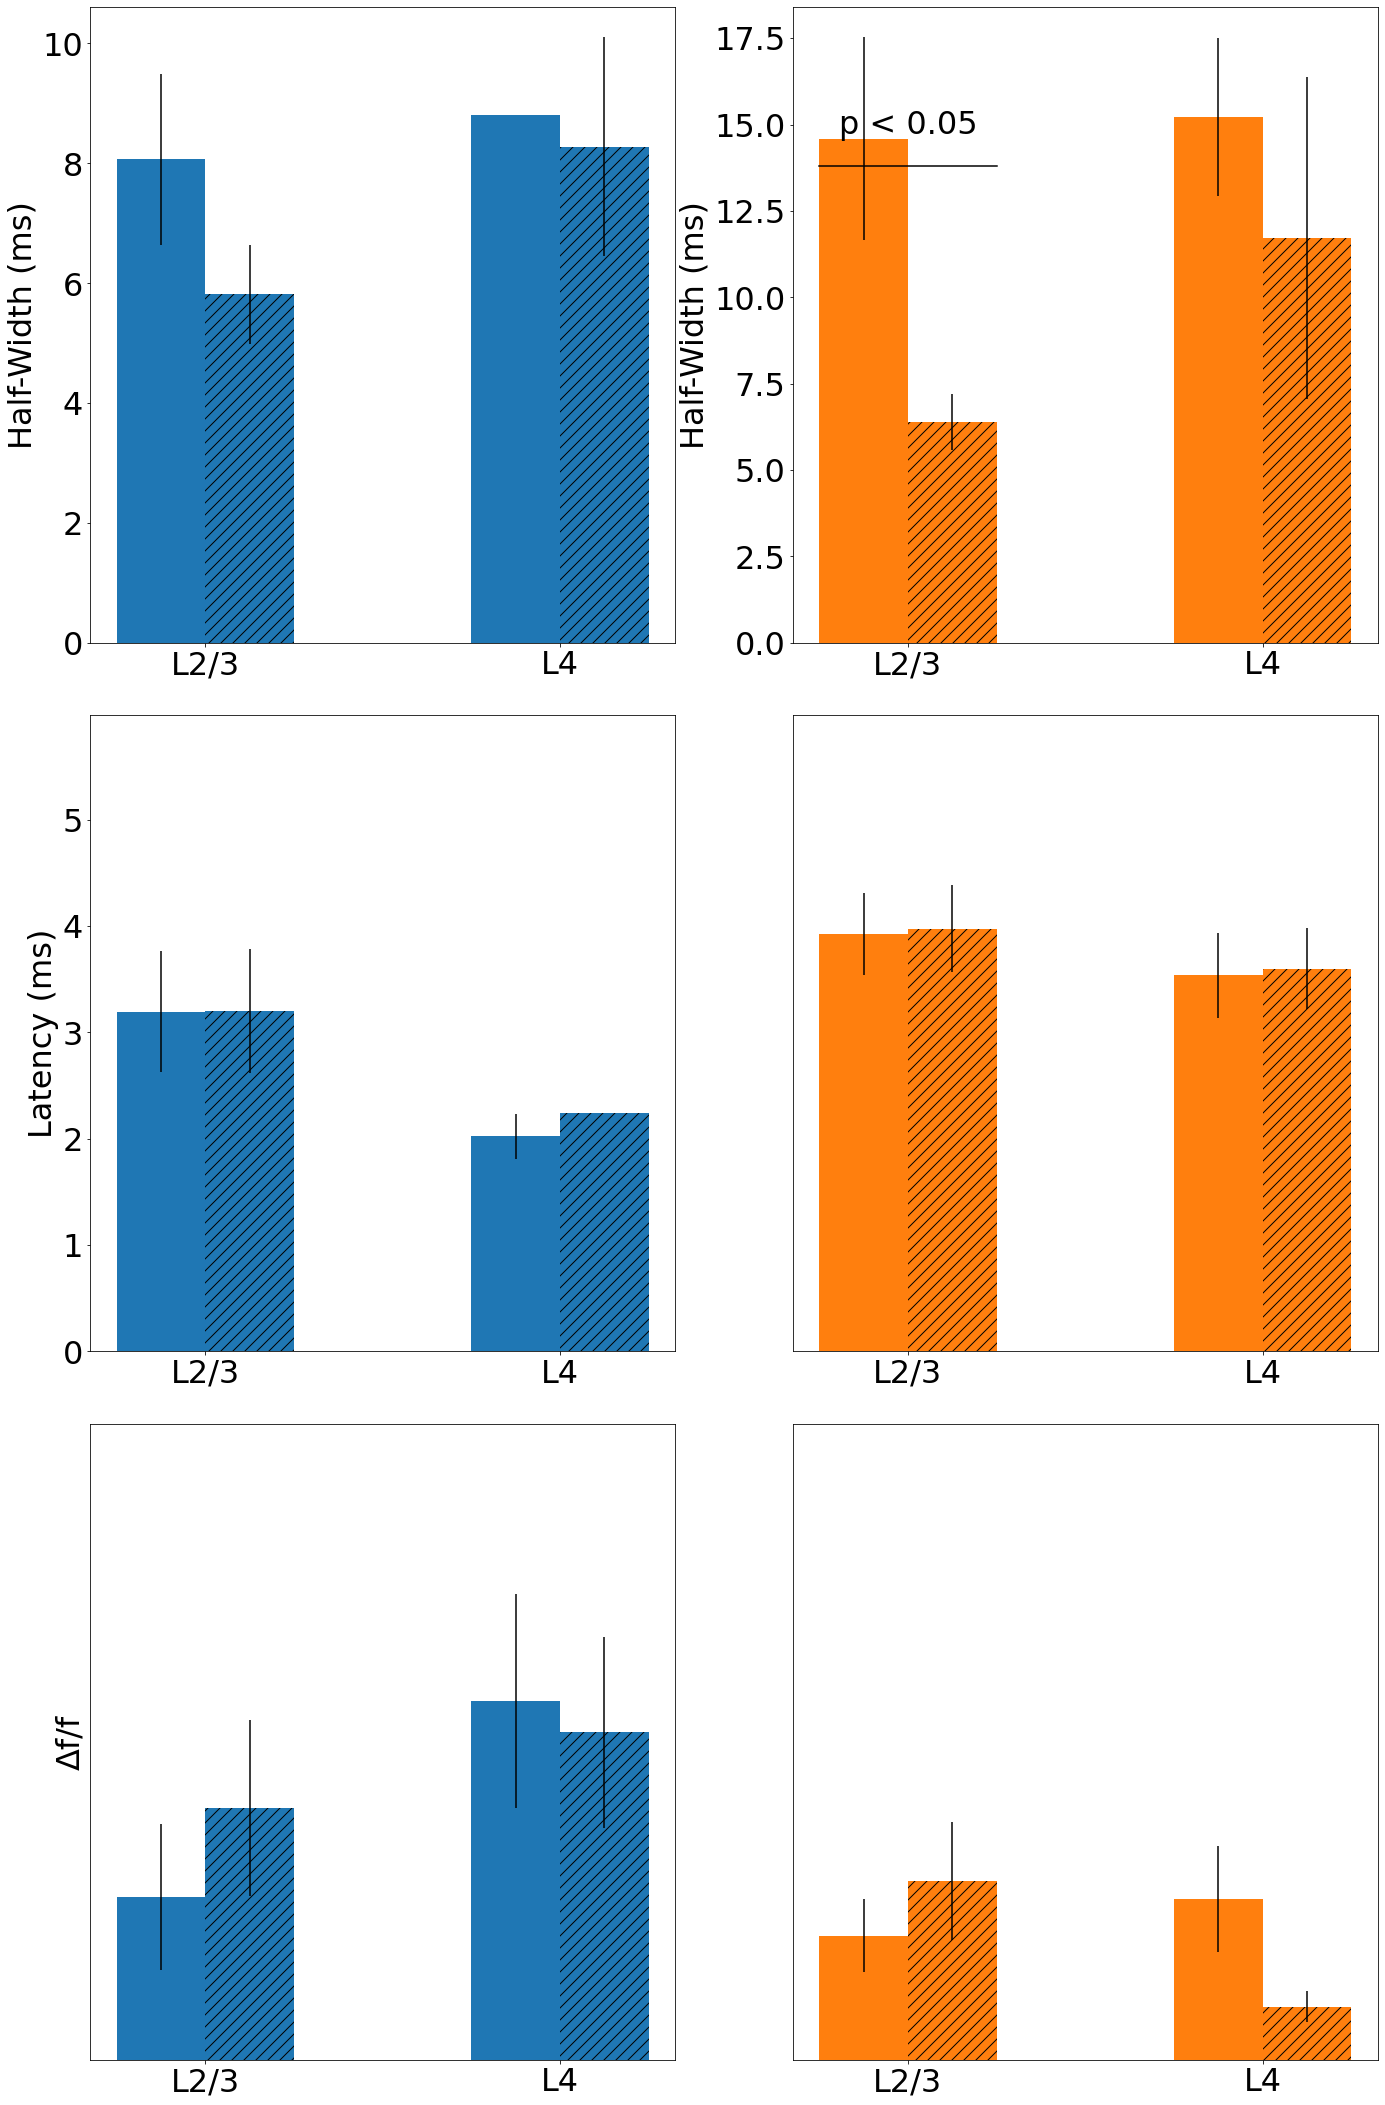

In [315]:
# plot the data, comparing L2/3 to L4 and ACSF to NBQX and home (ROI == 1) to neighbor (ROI > 1)

# font size
plt.rcParams.update({'font.size': 32})

fig, ax = plt.subplots(3, 2, figsize=(20, 30))
layers = ['L2/3', 'L4']
drug = ['ACSF', 'NBQX']

handles = []
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        
        hatch = '//' if d == 'NBQX' else None
        for roi in [1, 2]:
            col = 'tab:blue' if roi == 1 else 'tab:orange'
            roi_df = hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == d) & (hw_lat_df['ROI'] == roi)]
            l = ax[0][roi-1].bar([i + j/4-.125], np.mean(roi_df['halfwidth']), yerr=sem(roi_df['halfwidth']), label=drug, width=.25, color=col, hatch=hatch)
            ax[1][roi-1].bar([i + j/4-.125], np.mean(roi_df['latency']), yerr=sem(roi_df['latency']), label=drug, width=.25, color=col, hatch=hatch)
            ax[2][roi-1].bar([i + j/4-.125], np.mean(roi_df['amp']), yerr=sem(roi_df['amp']), label=drug, width=.25, color=col, hatch=hatch)
            handles.append(l)
        
ax[0][0].set_ylabel('Half-Width (ms)')
ax[1][0].set_ylabel('Latency (ms)')
ax[2][0].set_ylabel('Δf/f')

for i in range(2):
    for j in range(3):
        ax[j][i].set_xticks([0, 1])
        ax[j][i].set_xticklabels(layers)

# autoscale y-axis for each pair of subplots togethere
for i in range(1,3):
    y_max = max(ax[i][0].get_ylim()[1], ax[i][1].get_ylim()[1]) * 1.3
    ax[i][0].set_ylim(0, y_max)
    ax[i][1].set_ylim(0, y_max)
    ax[i][1].set_yticks([])
ax[2][0].set_yticks([])

# significance testing
for i, layer in enumerate(layers):
    for roi in [1, 2]:
        for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
            t_stat, p_val = ttest_ind(hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == 'ACSF') & (hw_lat_df['ROI'] == roi)][metric],
                                      hw_lat_df[(hw_lat_df['Layer'] == layer) & (hw_lat_df['drug'] == 'NBQX') & (hw_lat_df['ROI'] == roi)][metric])
            if p_val < 0.05:
                ax[j][roi-1].text((i), ax[j][roi-1].get_ylim()[1] * 0.8, 'p < 0.05', ha='center')

                # draw bar between ACSF and NBQX
                ax[j][roi-1].plot([i -.25, i + .25], [ax[j][roi-1].get_ylim()[1] * 0.75, ax[j][roi-1].get_ylim()[1] * 0.75], color='black')
            #else:
            #    ax[j][roi-1].text((i + .125), ax[j][roi-1].get_ylim()[1] * 0.8, str(p_val)[:5], ha='center')

handles = [handles[1], handles[3]]
#ax[0][1].legend(handles=handles, labels=['ACSF', '+NBQX'], loc='upper left')
ax[0][1].set_ylabel('Half-Width (ms)')
#ax[0][0].set_title('Home Barrel')
#ax[0][1].set_title('Neighbor Barrel')
plt.tight_layout()
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/hw_lat_amp.png')
plt.show()


In [316]:
# velocity analysis 
# read in velocity ladders
ladder_csv = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/export_summary_ladders.csv'
ladder_df = pd.read_csv(ladder_csv)
ladder_df['latency'] -= 48.6

# add a new column Dist_from_home_barrel
ladder_df['Dist_from_home_barrel'] = np.nan

# add a new column resides_in_barrel
ladder_df['resides_in_barrel'] = np.nan

# and for velocity
ladder_df['instantaneous_velocity'] = np.nan

ladder_df

ROI       amp       snr  latency  halfwidth  Stim_Distance   X_Center  \
0      1  0.408552  19.71280   3.9030   16.65070     272.917570  34.263889   
1      2  0.462050  27.53930   3.9159   14.44350     256.320112  36.851351   
2      3  0.441868  28.27000   3.8743   13.63680     239.774894  38.767123   
3      4  0.466602  22.11340   3.8636   13.22210     223.293529  40.816901   
4      5  0.526346  26.86690   3.7651   10.10290     206.891276  43.818182   
..   ...       ...       ...      ...        ...            ...        ...   
811   23  0.891664   6.89549   4.2499    4.98453     270.732340  64.188679   
812   24  0.890471   8.54388   4.0276    5.25165     285.236744  65.875000   
813   25  0.819354   6.14769   4.6185    6.57728     299.879976  68.851351   
814   26  0.807898   3.57018   3.7011   10.02130     313.955411  71.740741   
815   27  0.855839   2.34882   3.8461   37.79380     328.249905  74.400000   

      Y_Center                 ROI_Set        Date  Slice  Location  \
0    10.236111   1_roi_output__ladder_   6/26/2024      1         1   
1    12.054054   1_roi_output__ladder_   6/26/2024      1         1   
2    14.273973   1_roi_output__ladder_   6/26/2024      1         1   
3    16.338028   1_roi_output__ladder_   6/26/2024      1         1   
4    17.766234   1_roi_output__ladder_   6/26/2024      1         1   
..         ...                     ...         ...    ...       ...   
811  10.188679  2_rois_output__ladder_  12/20/2024      2         3   
812   7.729167  2_rois_output__ladder_  12/20/2024      2         3   
813   6.040541  2_rois_output__ladder_  12/20/2024      2         3   
814   4.351852  2_rois_output__ladder_  12/20/2024      2         3   
815   2.514286  2_rois_output__ladder_  12/20/2024      2         3   

     Recording                                              trace  \
0            1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
1            1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
2            1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
3            1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
4            1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/Ann...   
..         ...                                                ...   
811          1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
812          1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
813          1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
814          1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   
815          1  C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23...   

     Dist_from_home_barrel  resides_in_barrel  instantaneous_velocity  
0                      NaN                NaN                     NaN  
1                      NaN                NaN                     NaN  
2                      NaN                NaN                     NaN  
3                      NaN                NaN                     NaN  
4                      NaN                NaN                     NaN  
..                     ...                ...                     ...  
811                    NaN                NaN                     NaN  
812                    NaN                NaN                     NaN  
813                    NaN                NaN                     NaN  
814                    NaN                NaN                     NaN  
815                    NaN                NaN                     NaN  

[816 rows x 17 columns]

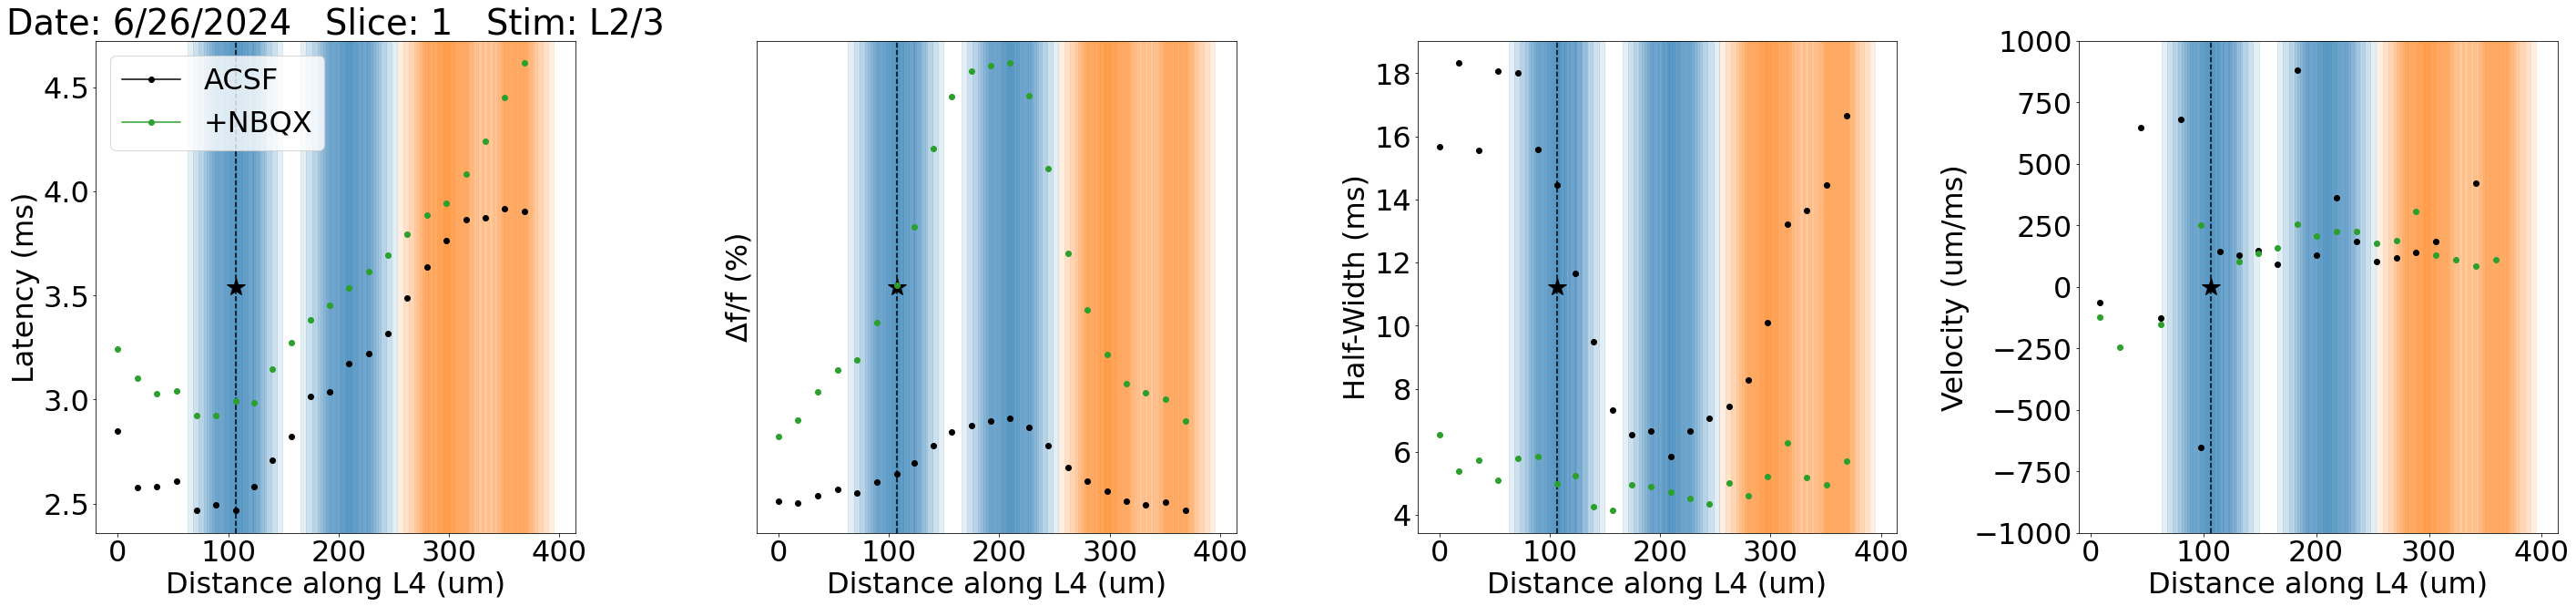

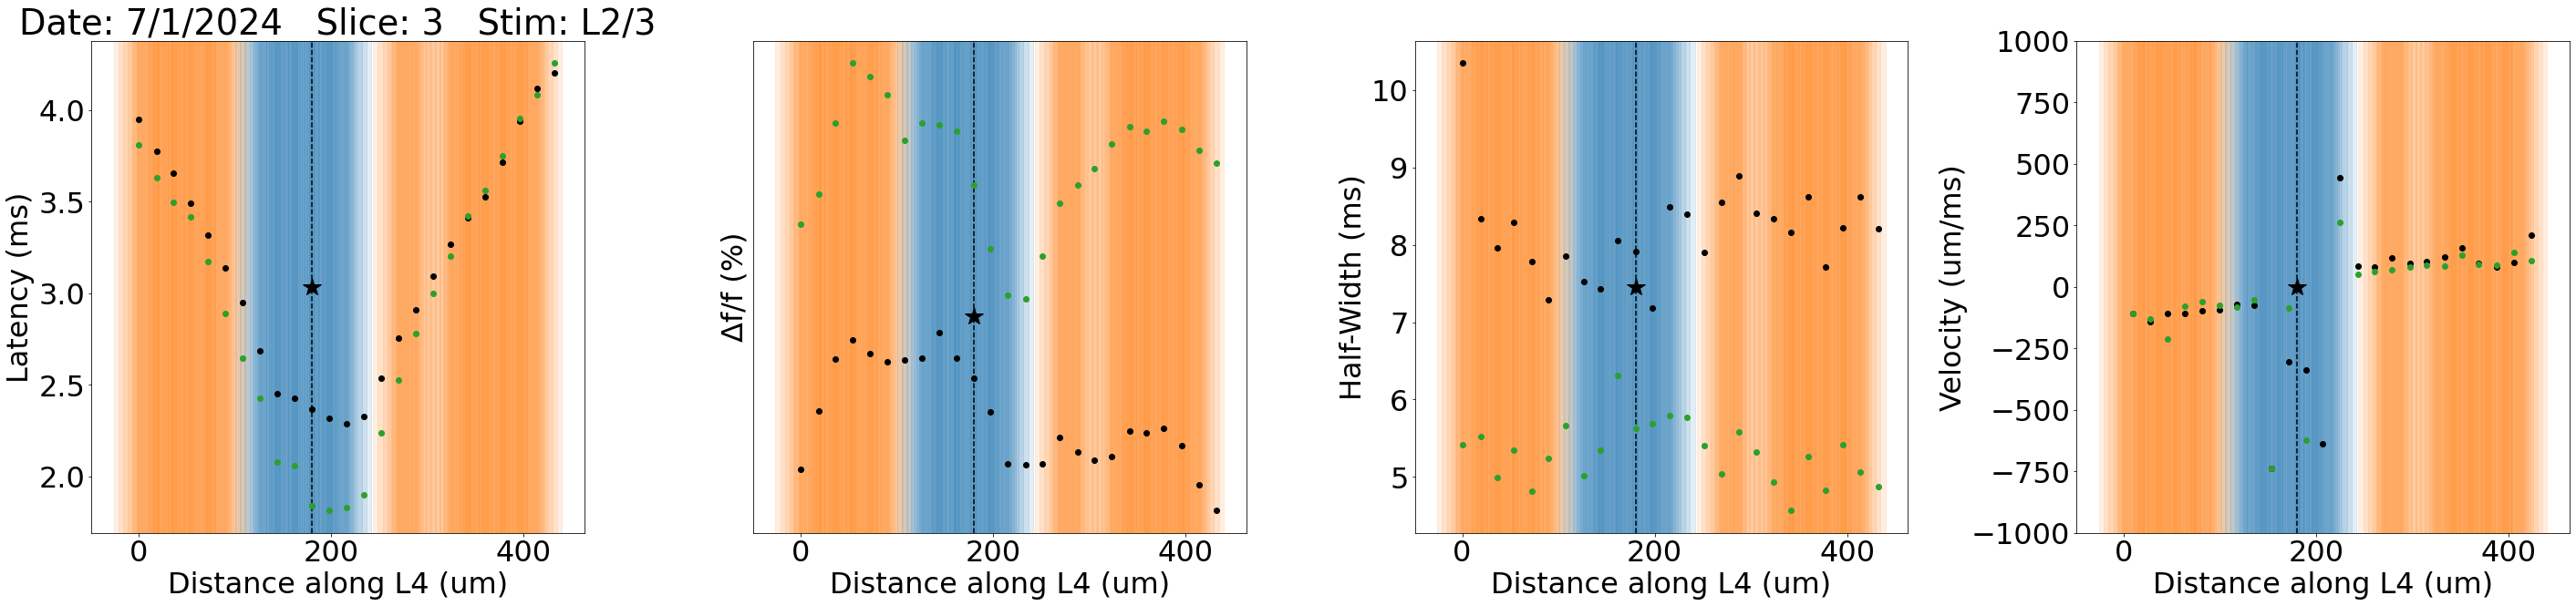

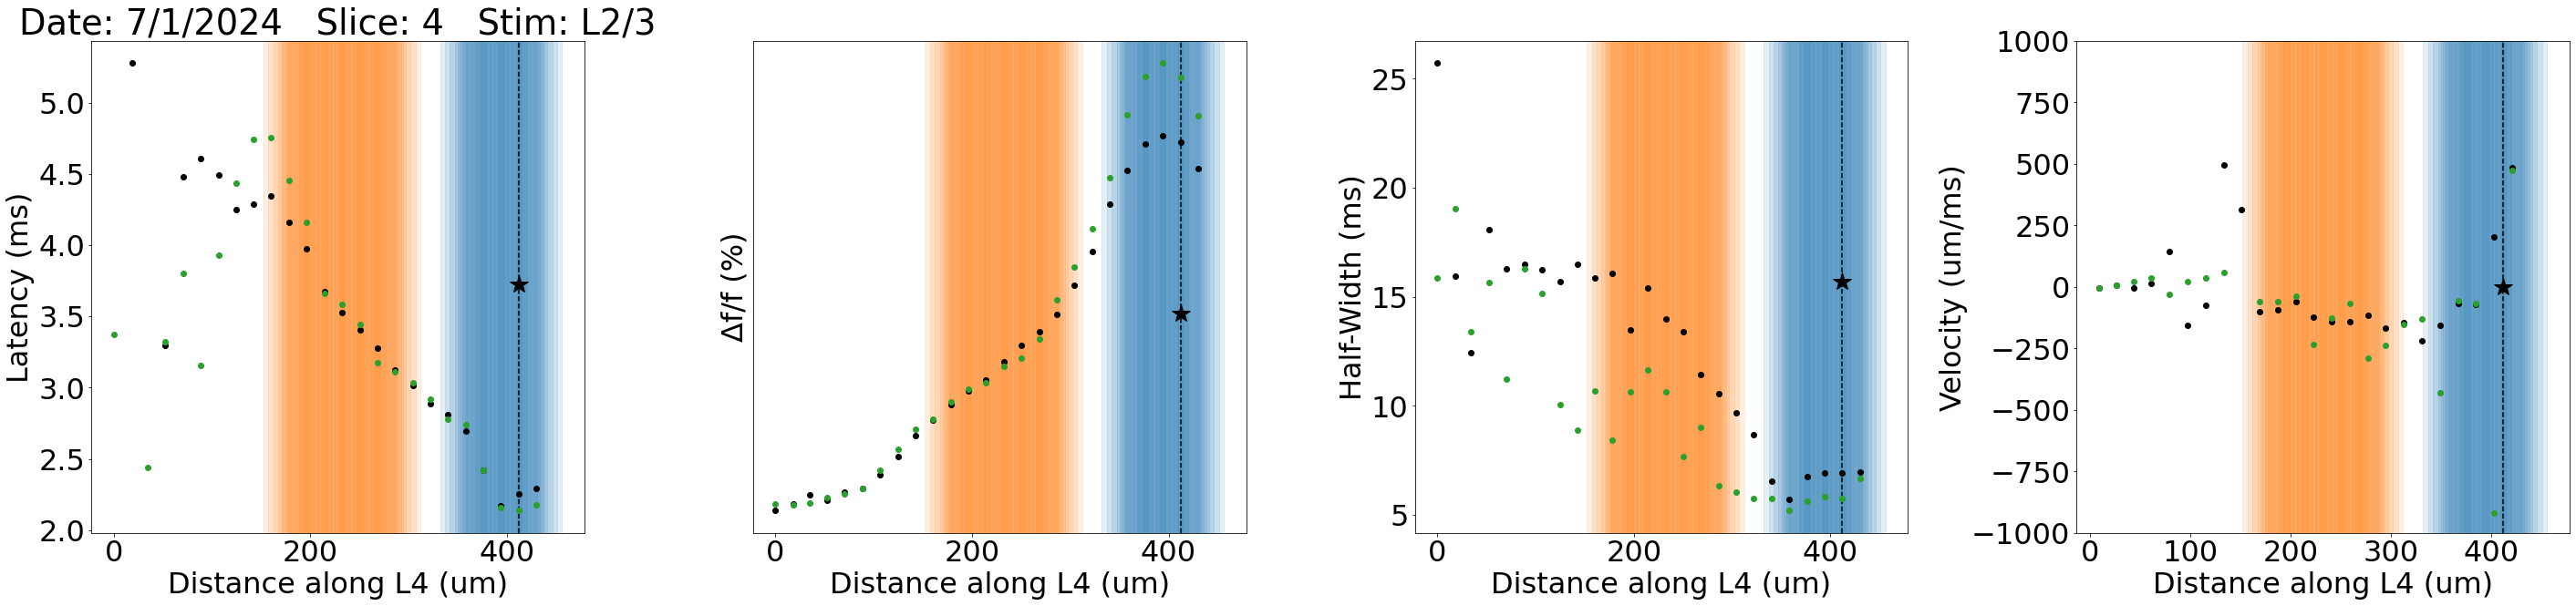

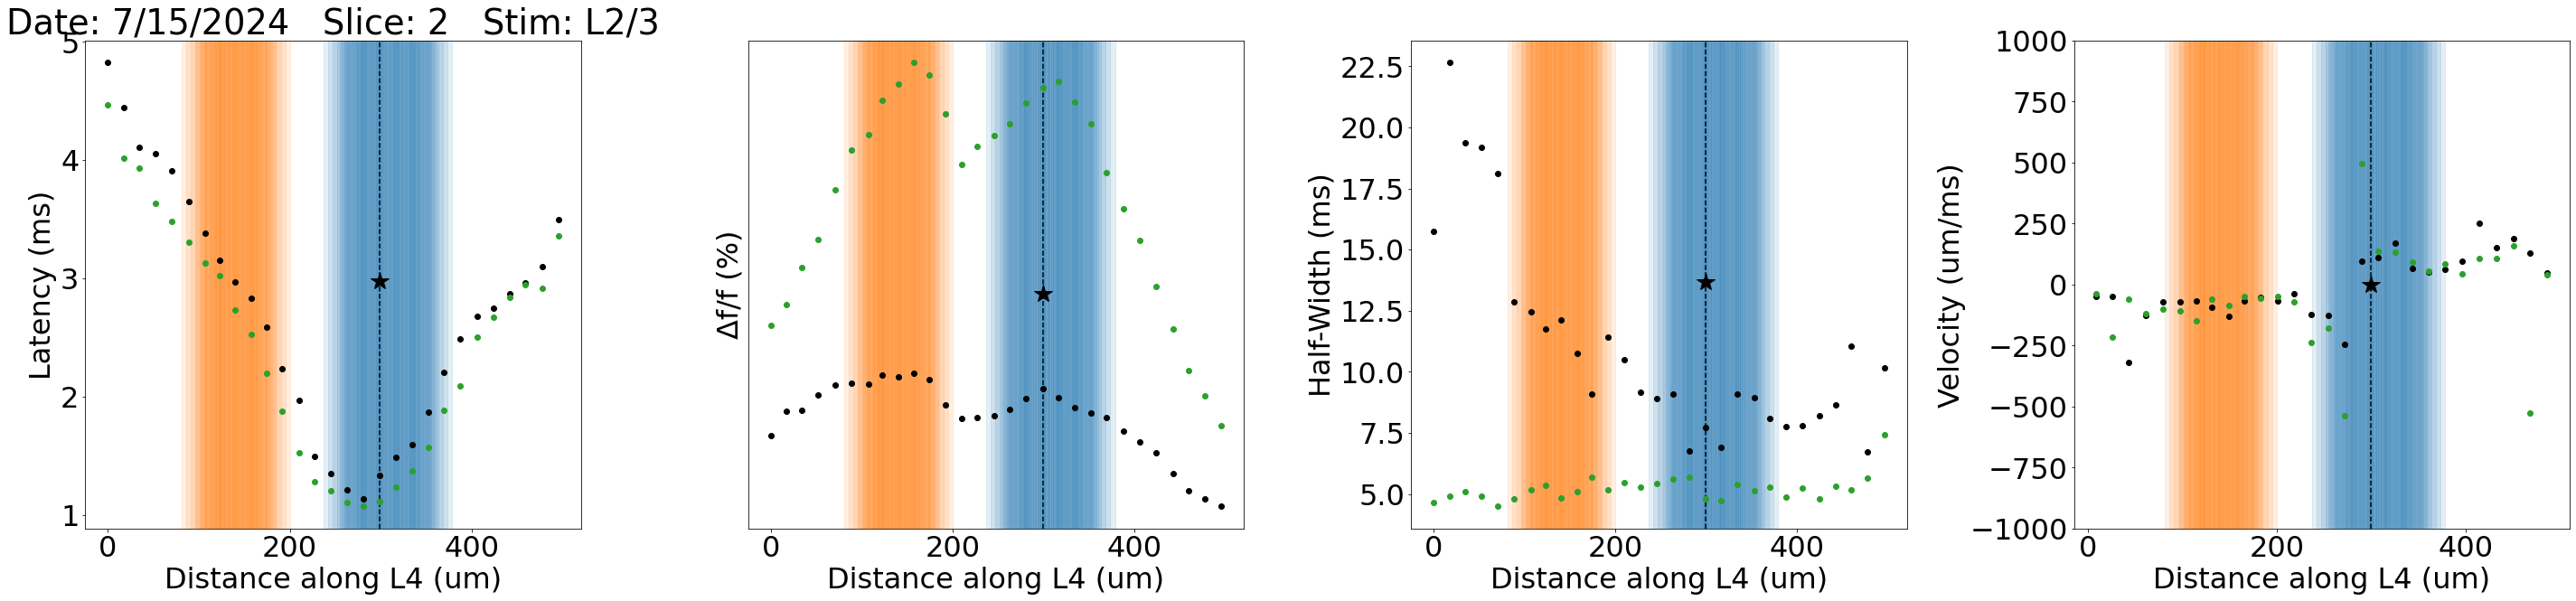

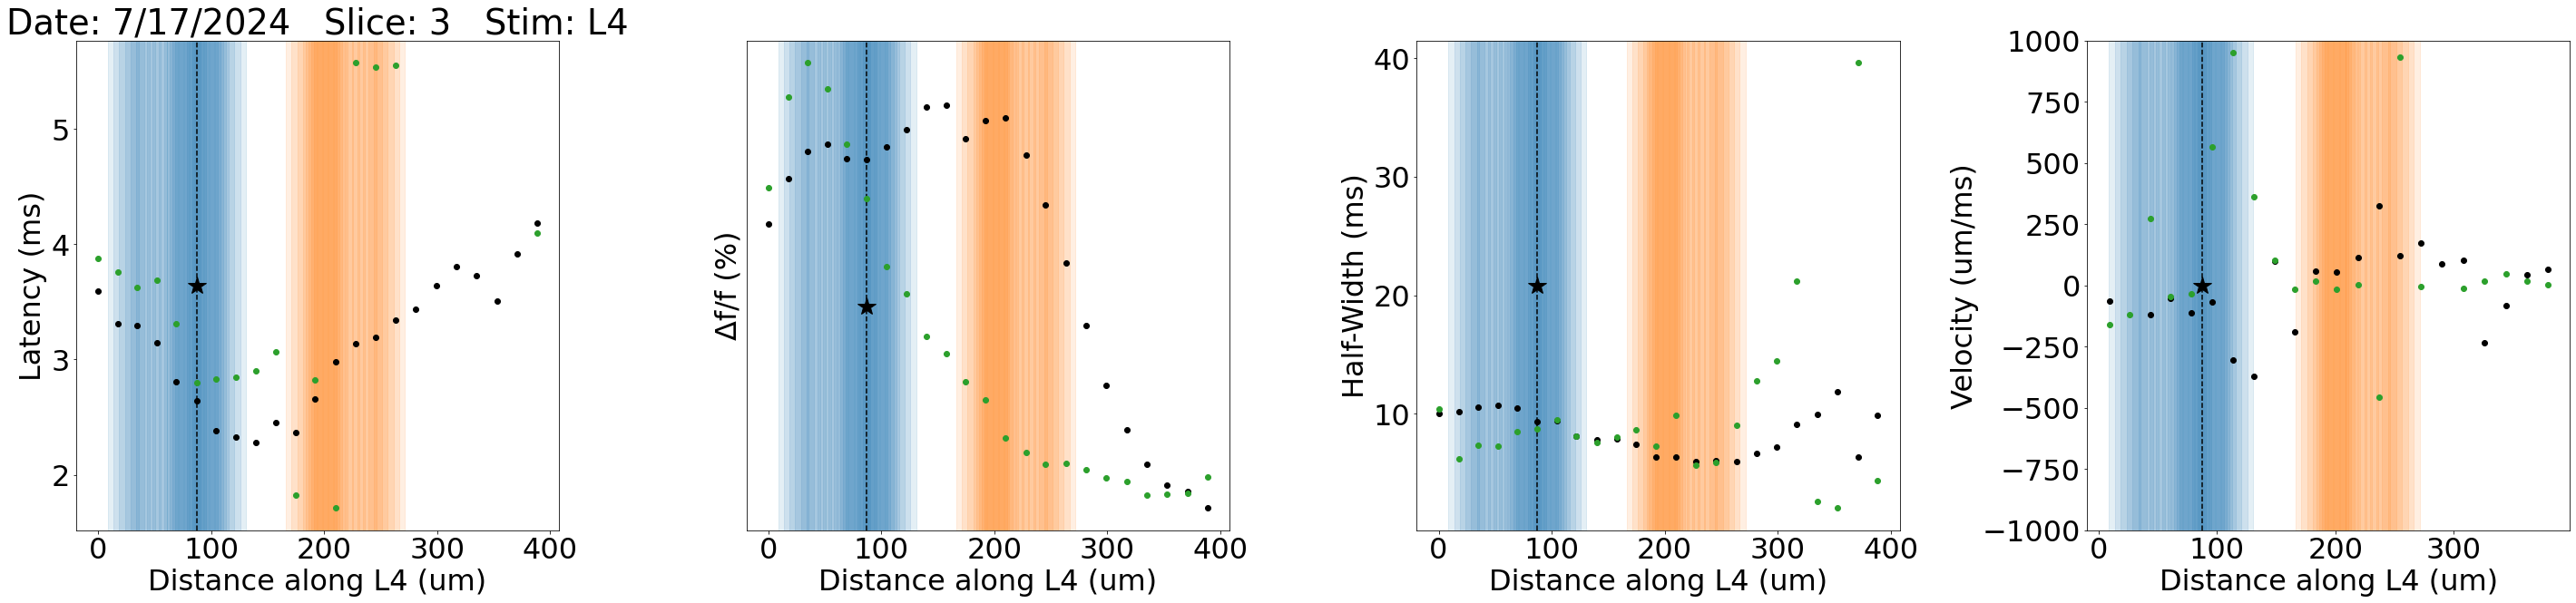

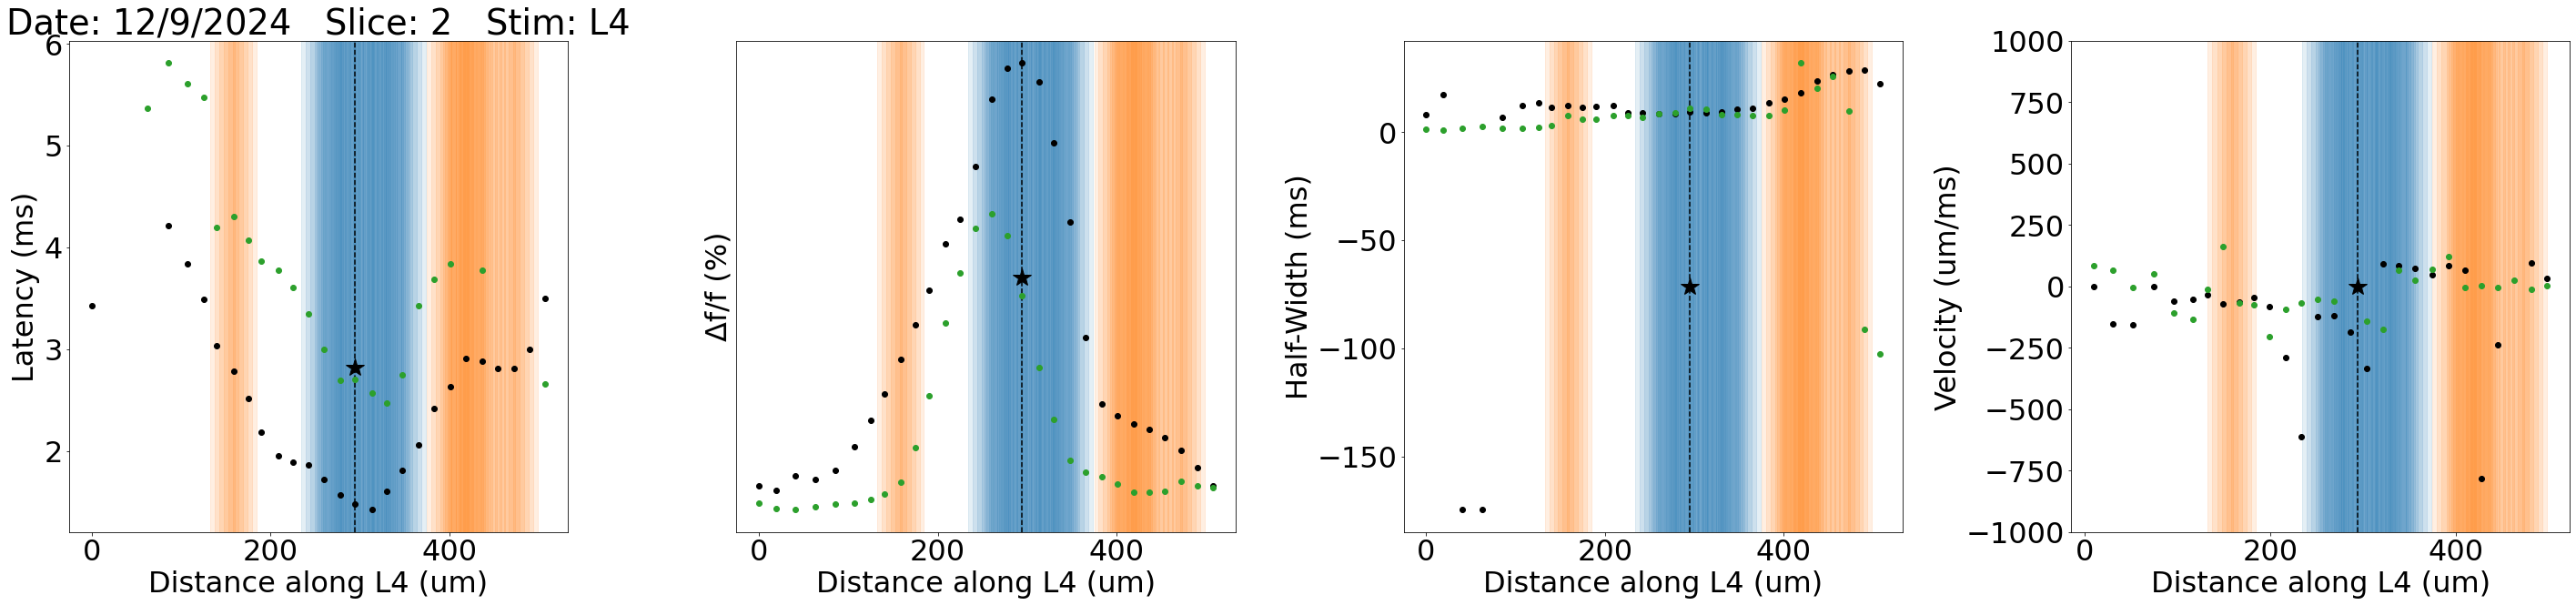

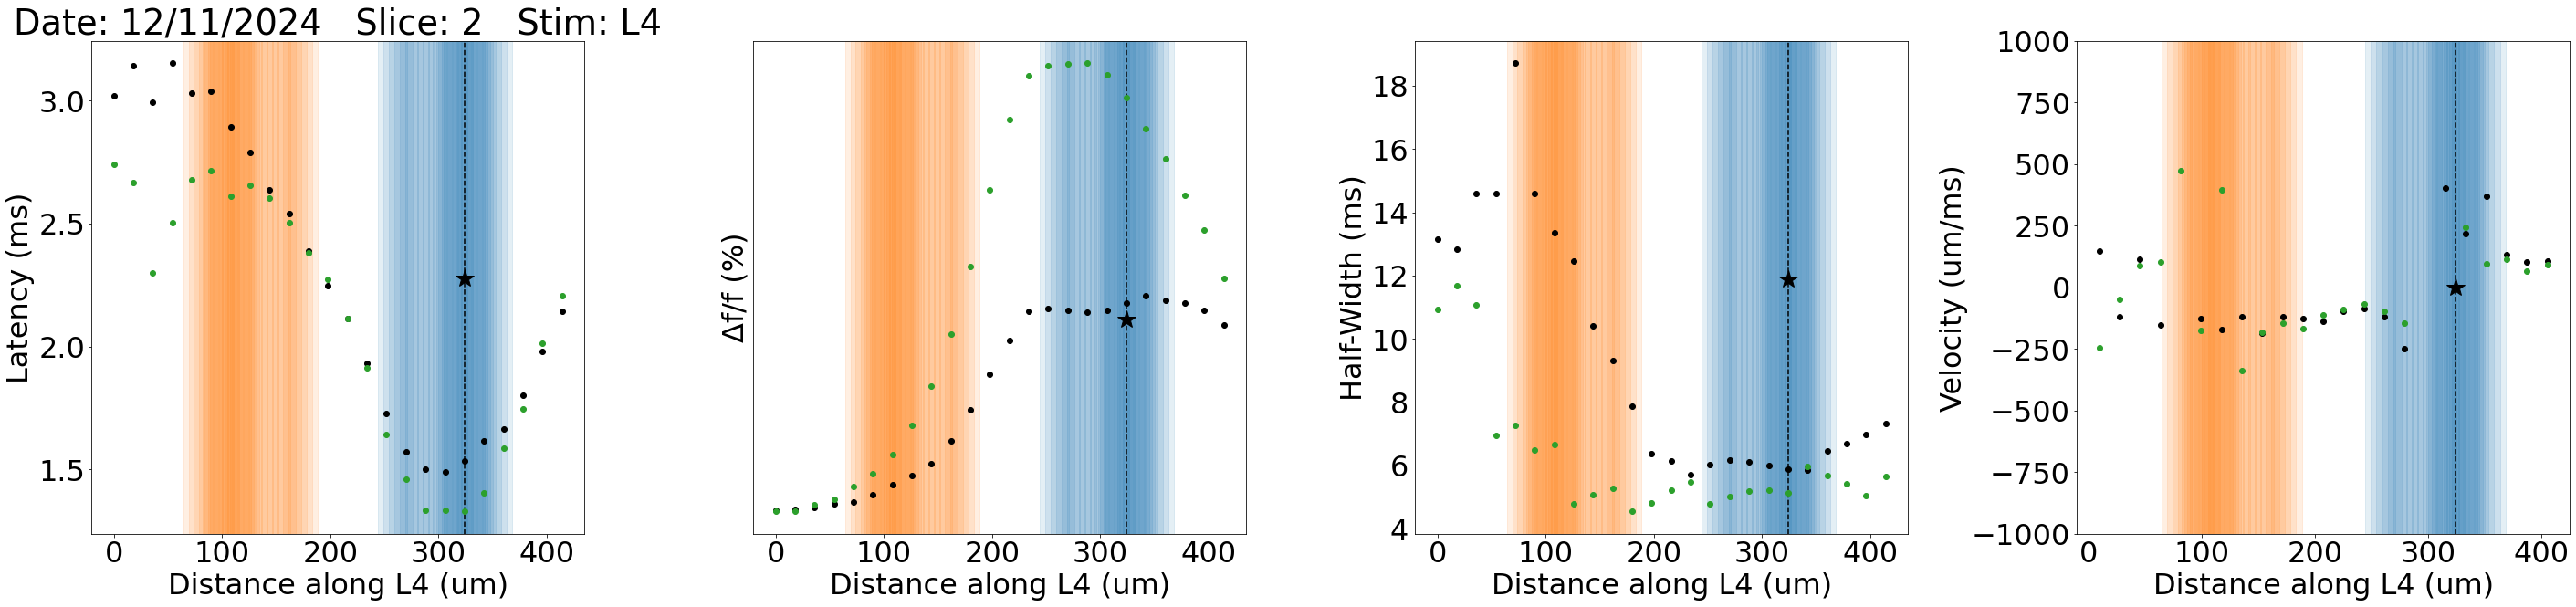

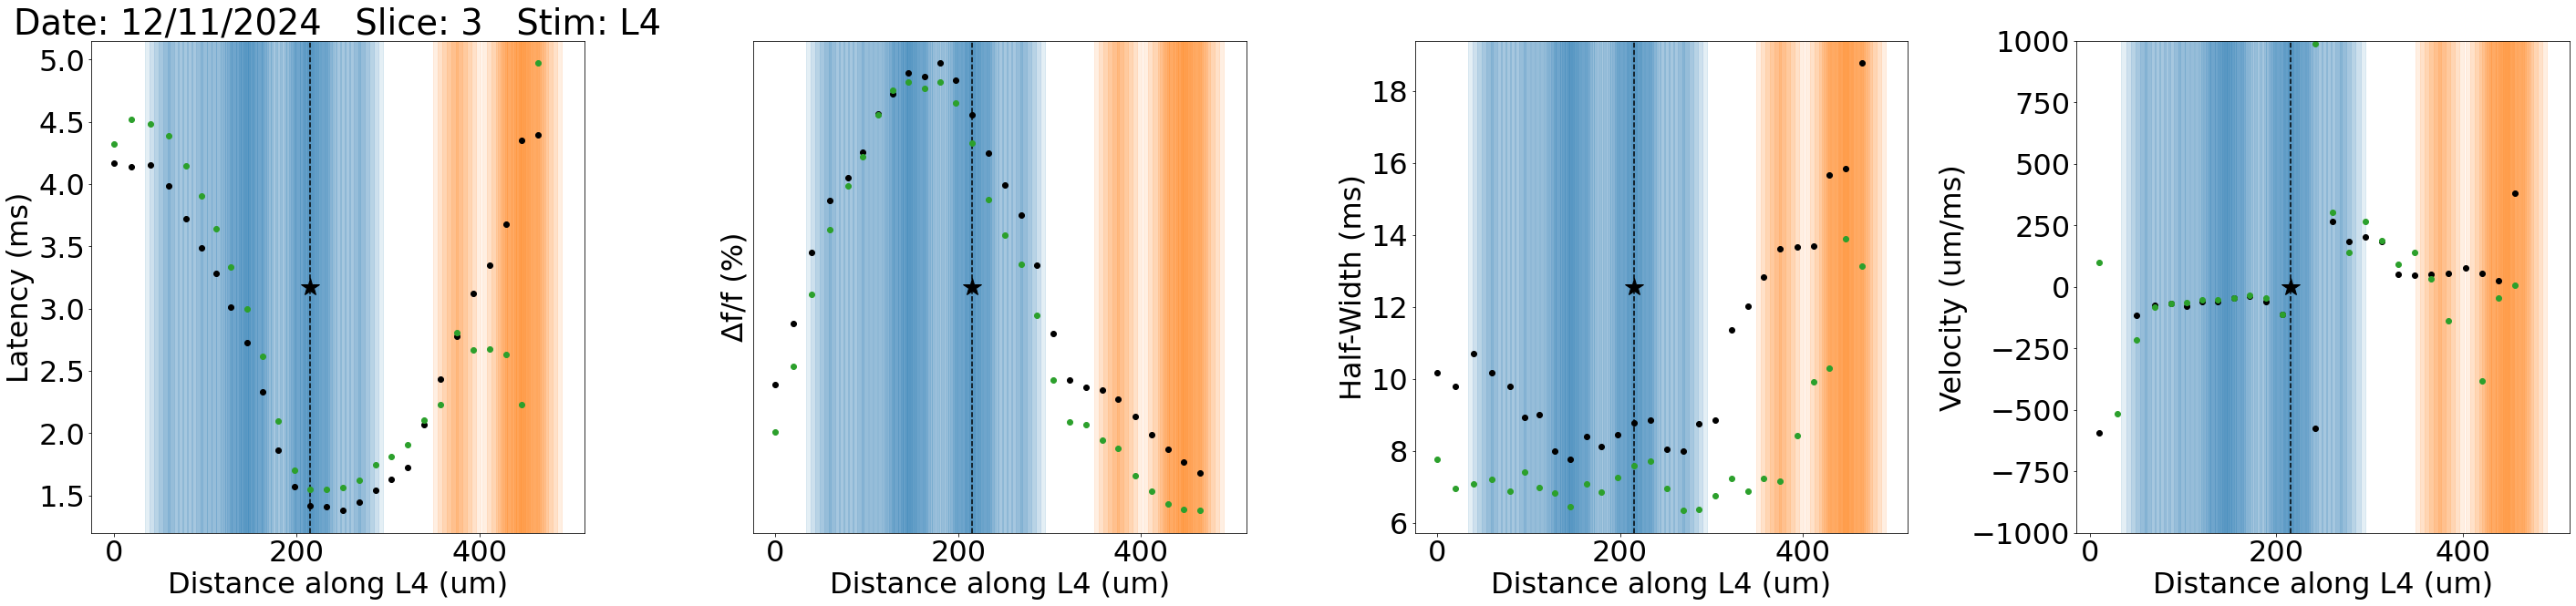

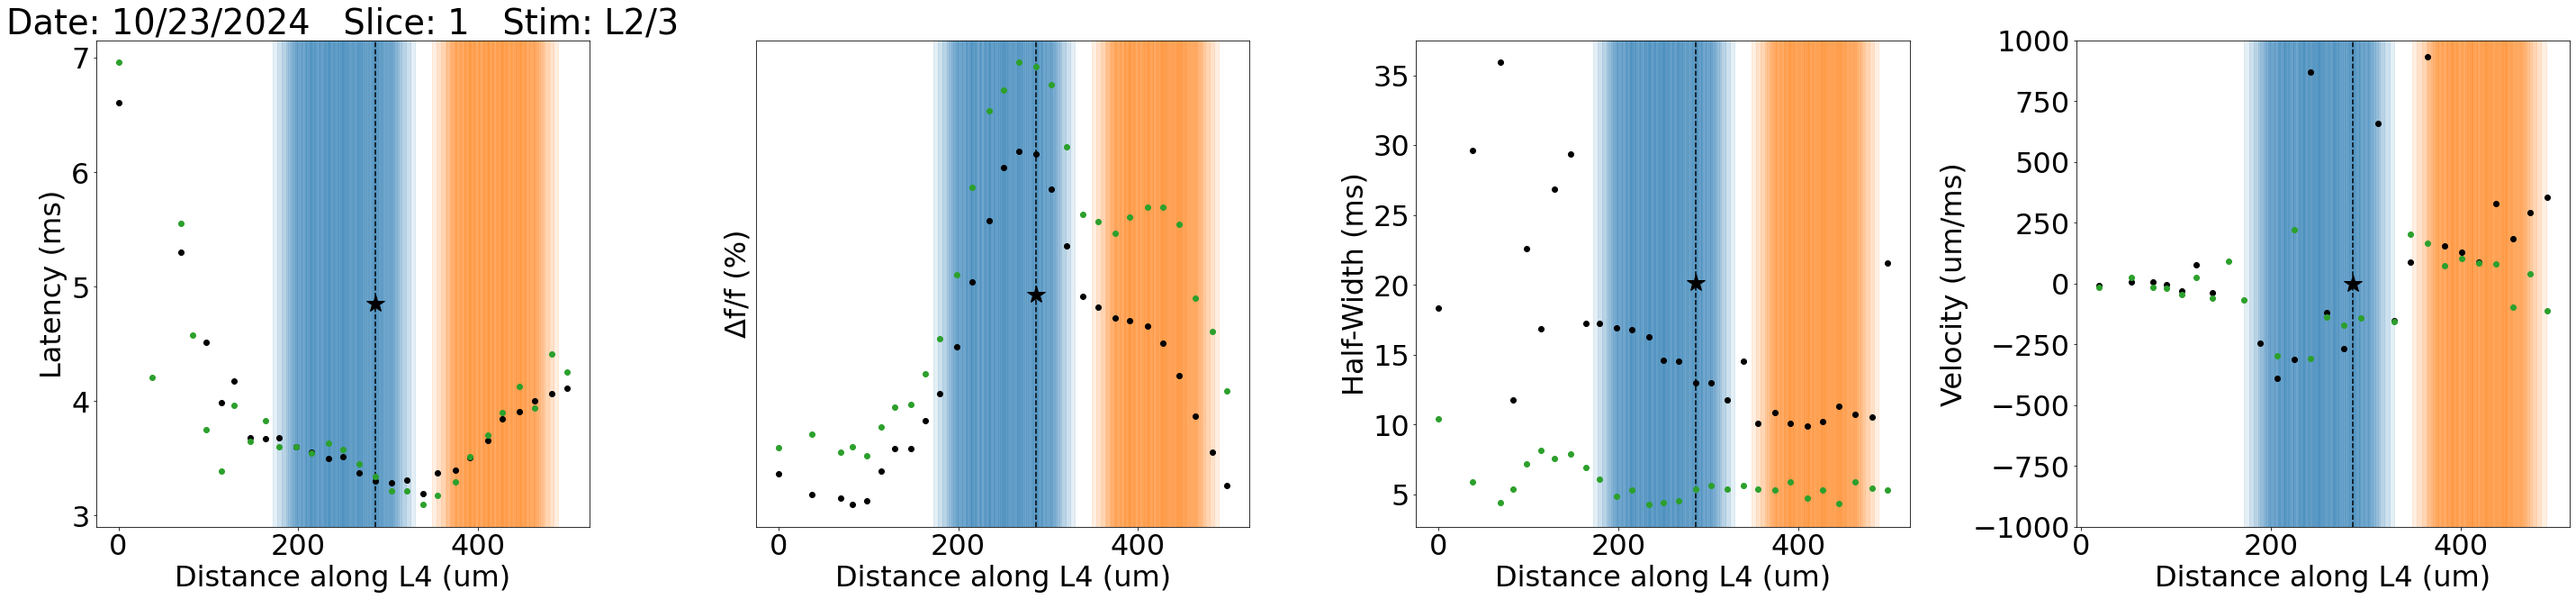

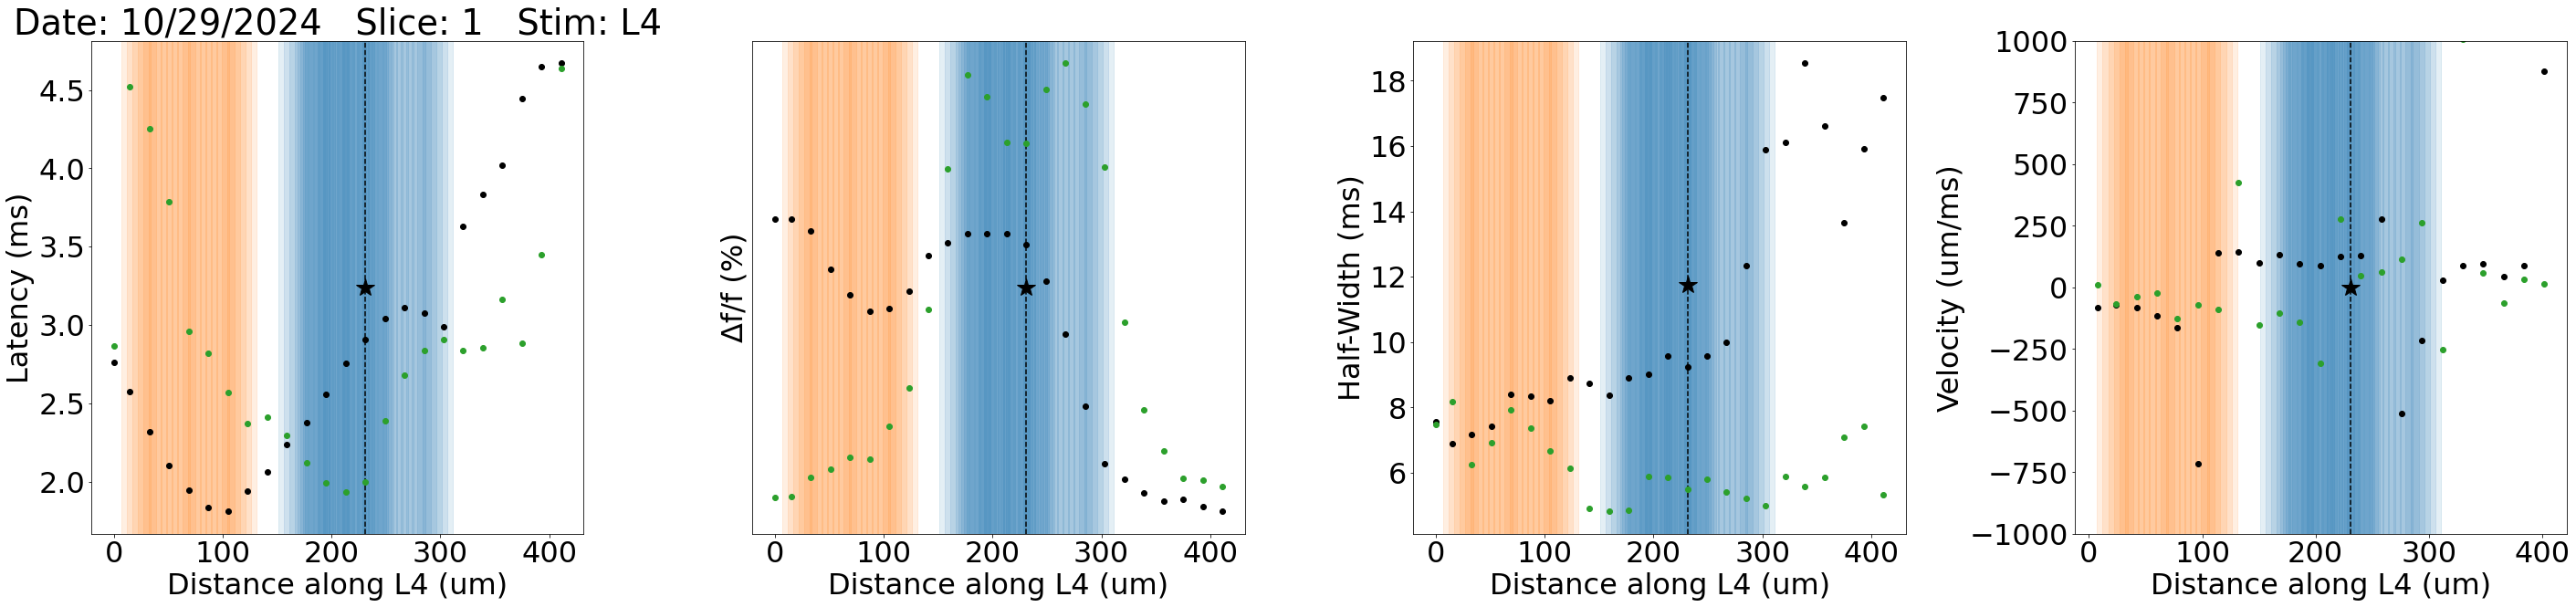

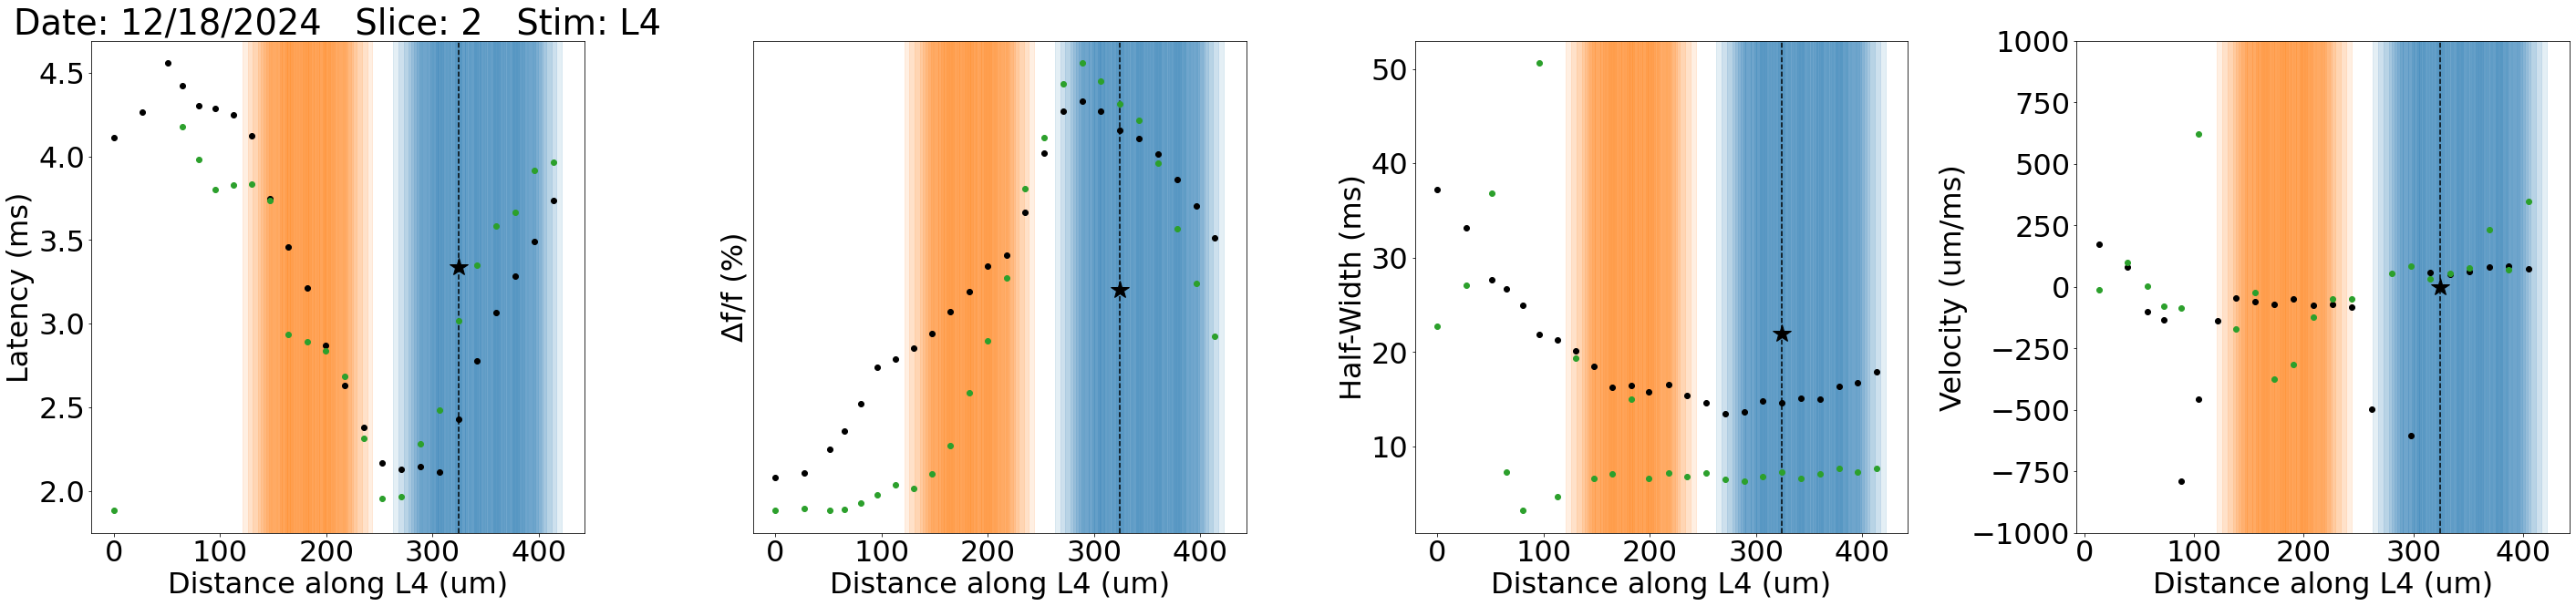

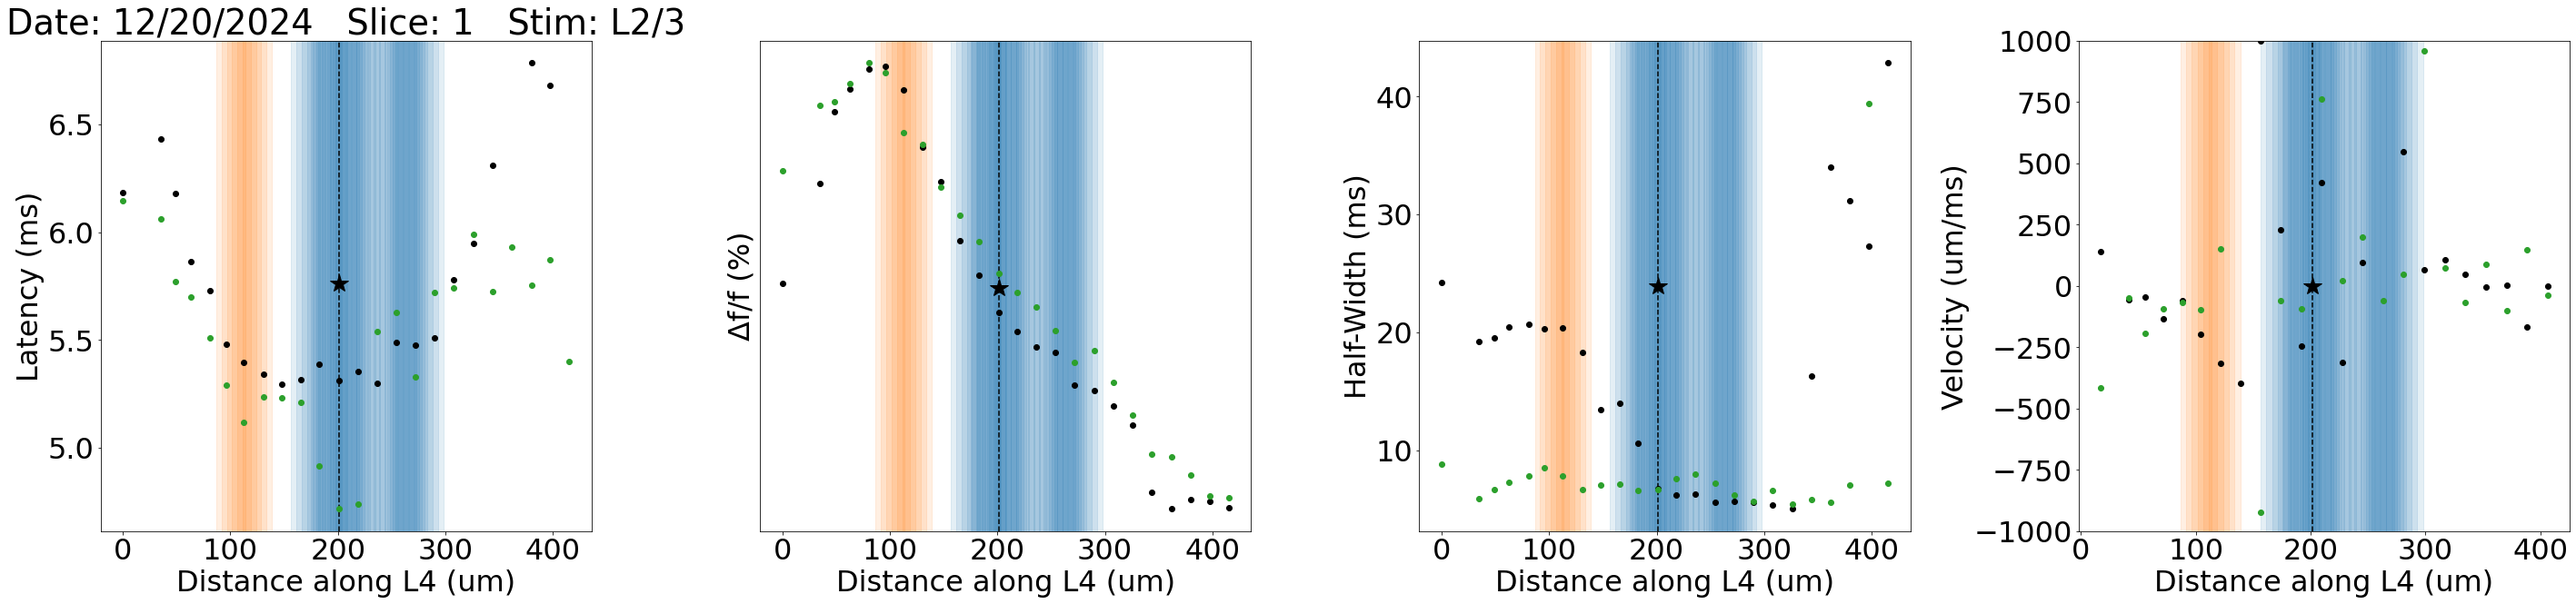

In [320]:
def identify_overlap_barrel(barrel_rois, roi):
    """ return a list of bools of whether roi overlaps w the barrel in barrel_rois
        0 - home barrel, 1 or 2 - neighbor barrel """
    overlap_ctr = OverlapCounterROI([], [])
    is_overlap = [overlap_ctr.do_rois_overlap(barrel, roi) for barrel in barrel_rois]
    return is_overlap

# for each Slice/Location/Recording, plot the latency of each ladder ROI
num_legends = 1
for date in ladder_df['Date'].unique():
    date_df = ladder_df[ladder_df['Date'] == date]
    for slic in date_df['Slice'].unique():
        slic_df = date_df[date_df['Slice'] == slic]

        handles = []
        # look up ROI file from crossing_data
        if crossing_data[(crossing_data['Date'] == date) &
                         (crossing_data['Slice'] == slic)].empty:
            continue
        fig, ax = plt.subplots(1, 4, figsize=(40, 10))

        for rec in slic_df['Recording'].unique():
            rec_df = slic_df[slic_df['Recording'] == rec]

            # look up ROI file from crossing_data
            barrel_df_sub = crossing_data[(crossing_data['Date'] == date) &
                                    (crossing_data['Slice'] == slic) &
                                    (crossing_data['Recording'] == rec) ]
            if barrel_df_sub.empty:
                print('No ROI file found for ', date, slic, rec)
                continue

            roi_file = barrel_df_sub['ROI file'].values[0]
            drug = barrel_df_sub['drug'].values[0]
            stim_layer = barrel_df_sub['Layer'].values[0]

            # save roi_file, drug, and stim_layer in ladder_df in new columns
            ladder_df.loc[(ladder_df['Date'] == date) &
                            (ladder_df['Slice'] == slic) &
                            (ladder_df['Recording'] == rec), 'ROI file'] = roi_file
            ladder_df.loc[(ladder_df['Date'] == date) &
                            (ladder_df['Slice'] == slic) &
                            (ladder_df['Recording'] == rec), 'drug'] = drug
            ladder_df.loc[(ladder_df['Date'] == date) &
                            (ladder_df['Slice'] == slic) &
                            (ladder_df['Recording'] == rec), 'Layer'] = stim_layer

            # read in the ROI file
            rois = ROIFileReader(roi_file).get_roi_list()

            # get the center of the home barrel
            home_barrel_center = LaminarROI(rois[0], input_diode_numbers=True).get_center()

            # convert from diode to pixel
            rois = [LaminarROI(roi, input_diode_numbers=True).get_points()
                        for roi in rois]

            # first roi is home barrel, rest are neighboring barrels
            home_barrel = rois[0]
            neighbor_barrels = rois[1:]

            for roi in rec_df['ROI'].unique():
                roi_df = rec_df[rec_df['ROI'] == roi]
                # get the center of the ROI
                x_center = roi_df['X_Center'].values[0]
                y_center = roi_df['Y_Center'].values[0]

                is_overlap = identify_overlap_barrel(rois, [[int(x_center), int(y_center)]])

                # also calculate distance from home barrel along barrel axis
                ln = Line(home_barrel_center, [x_center, y_center])
                dist = ln.get_length()

                resides_in_barrel = None
                if is_overlap[0]:
                    resides_in_barrel = 'Home'
                elif is_overlap[1] or (len(is_overlap) > 2 and is_overlap[2]):
                    resides_in_barrel = 'Neighbor'

                # store in ladder_df
                ladder_df.loc[(ladder_df['Date'] == date) & 
                                (ladder_df['Slice'] == slic) & 
                                (ladder_df['Recording'] == rec) & 
                                (ladder_df['ROI'] == roi), 'Dist_from_home_barrel'] = dist
                ladder_df.loc[(ladder_df['Date'] == date) & 
                                (ladder_df['Slice'] == slic) & 
                                (ladder_df['Recording'] == rec) & 
                                (ladder_df['ROI'] == roi), 'resides_in_barrel'] = resides_in_barrel

            # now calculate which ROI is the closest to the home barrel
            arg_min = rec_df['Dist_from_home_barrel'].argmin()
            # get the ROI of the closest ROI
            closest_roi = rec_df.iloc[arg_min]
            closest_x = closest_roi['X_Center']
            closest_y = closest_roi['Y_Center']

            # also, which ROI is closest to the stim (min Stim_Distance)
            arg_min_stim = rec_df['Stim_Distance'].argmin()
            closest_stim_roi = rec_df.iloc[arg_min_stim]
            
            for roi in rec_df['ROI'].unique():
                roi_df = rec_df[rec_df['ROI'] == roi]
                dist_to_closest_roi = Line([closest_x, closest_y], 
                                            [roi_df['X_Center'].values[0],
                                                roi_df['Y_Center'].values[0]]).get_length()

                # denote negative distances as those to one side of the closest ROI
                if roi_df['ROI'].values[0] > closest_roi['ROI']:
                    dist_to_closest_roi *= -1

                ladder_df.loc[(ladder_df['Date'] == date) &
                                (ladder_df['Slice'] == slic) &
                                (ladder_df['Recording'] == rec) &
                                (ladder_df['ROI'] == roi), 'Dist_from_home_barrel'] = dist_to_closest_roi * 6.0  # px -> um
                
                # refresh data before plotting
                roi_df = ladder_df[(ladder_df['Date'] == date) &
                                (ladder_df['Slice'] == slic) &
                                (ladder_df['Recording'] == rec) &
                                (ladder_df['ROI'] == roi)]

                color = 'black' if drug == 'ACSF' else 'tab:green'
                region_color = None
                if roi_df['resides_in_barrel'].values[0] == 'Home':
                    region_color = 'tab:blue'
                if np.abs(roi - closest_stim_roi['ROI']) < 2:
                    region_color = 'tab:blue'
                elif roi_df['resides_in_barrel'].values[0] == 'Neighbor':
                    region_color = 'tab:orange'
                
                for sub_ax in ax:
                    # shade a vertical region of each plot around this ROI
                    if region_color is not None:
                        for radius in range(1, 31, 5):
                            sub_ax.axvspan(roi_df['Dist_from_home_barrel'].values[0] - radius, 
                                        roi_df['Dist_from_home_barrel'].values[0] + radius, 
                                        color=region_color, alpha=0.06)
                    # draw a black dotted vertical line at the closest_stim_roi
                    if roi == closest_stim_roi['ROI'] and drug != 'ACSF':
                        sub_ax.axvline(x=roi_df['Dist_from_home_barrel'].values[0], color='black', linestyle='--')

                        # and a black star next to the line at 50% the middle of the y-axis scale
                        middle_y = (sub_ax.get_ylim()[0] + sub_ax.get_ylim()[1]) / 2
                        if sub_ax == ax[3]:
                            middle_y = 0

                        sub_ax.plot(roi_df['Dist_from_home_barrel'].values[0], middle_y, 
                                    color='black', marker='*', markersize=20)

                # plot the latency vs distance from home barrel
                if 7 > roi_df['latency'].values[0] > 1:
                    ax[0].plot(roi_df['Dist_from_home_barrel'], roi_df['latency'], 
                            label=str(resides_in_barrel),
                            color=color, marker='o')

                # Now also plot the amplitude vs distance from home barrel
                ax[1].plot(roi_df['Dist_from_home_barrel'], roi_df['amp'] / 10, 
                            label=drug,
                            color=color, marker='o')

                # now also plot the half-width vs distance from home barrel
                ax[2].plot(roi_df['Dist_from_home_barrel'], roi_df['halfwidth'], 
                            label=drug,
                            color=color, marker='o')
            
            # now we also want to calculate the velocity of the ladder
            # for each pair of ROIs i and i+1, calculate the velocity as the distance between the two ROIs
            # divided by the difference in latency between the two ROIs
            # this will give the velocity in um/ms
            for i in range(1, len(rec_df)):
                roi1 = rec_df.iloc[i-1]
                roi2 = rec_df.iloc[i]
                dist = roi2['Dist_from_home_barrel'] - roi1['Dist_from_home_barrel']
                position = (roi2['Dist_from_home_barrel'] + roi1['Dist_from_home_barrel']) / 2
                latency_diff = roi2['latency'] - roi1['latency']
                velocity = dist / latency_diff
                if 5000 > velocity > -1000:
                    ax[3].plot(position, velocity, color=color, linestyle='-', marker='o')
                    # track this in the df as the velocity of roi i-1
                    ladder_df.loc[(ladder_df['Date'] == date) &
                                    (ladder_df['Slice'] == slic) &
                                    (ladder_df['Recording'] == rec) &
                                    (ladder_df['ROI'] == roi1['ROI']), 'instantaneous_velocity'] = velocity
                


        for sub_ax in ax:
            sub_ax.set_xlabel('Distance along L4 (um)')
        ax[0].set_ylabel('Latency (ms)')
        ax[1].set_ylabel('Δf/f (%)')
        ax[2].set_ylabel('Half-Width (ms)')
        ax[3].set_ylabel('Velocity (um/ms)')
        ax[1].set_yticks([])
        ax[3].set_ylim(-1000, 1000)
        ax[0].set_title('Date: ' + date + '   Slice: ' + str(slic) + '   Stim: ' + stim_layer )
        handles = ax[0].get_legend_handles_labels()
        handles = [handles[0][0], handles[0][-1]]
        if num_legends > 0:
            ax[0].legend(handles=handles, labels=['ACSF', '+NBQX'], loc='upper left')
            num_legends -= 1
        plt.tight_layout()
        plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/Ladder_velocity_plot_' \
                + date.replace('/', '-') + '_' + str(slic) + '_' + stim_layer.replace("/", "") + '_' + str(rec) + '_latency.png')
        plt.show()

L2/3 Neighbor ACSF 152.9 +/- 25.16 um/ms
L4 Neighbor ACSF 332.3 +/- 171.9 um/ms
L2/3 Neighbor NBQX 113.2 +/- 10.28 um/ms
L4 Neighbor NBQX 152.4 +/- 32.38 um/ms
0.13068948495021068


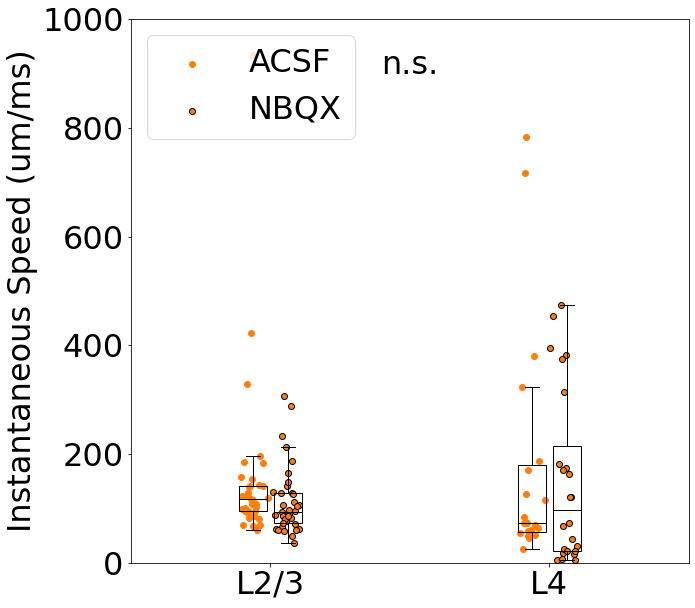

In [321]:
# make a 1-d scatter plot of the average speed
# broken down by home vs neighbor barrel and L2/3 vs L4
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
layers = ['L2/3', 'L4']
drug = ['ACSF', 'NBQX']
# boxplots of the average speed
for j, d in enumerate(drug):
    speeds = []
    positions = []
    for i, layer in enumerate(layers):
        for i_reg, region in enumerate(['Neighbor']):
            region_df = ladder_df[(ladder_df['Layer'] == layer) & 
                                    (ladder_df['drug'] == d) & 
                                    (ladder_df['resides_in_barrel'] == region)]
            speed = [s for s in list(np.abs(region_df["instantaneous_velocity"])) if not np.isnan(s)]

            speeds.append(speed)
            positions.append(i + j/8 - 1/16)
            # print the mean +/- sem of the speed
            print(layer, region, d, str(np.mean(speed))[:5], "+/-", str(sem(speed))[:5], "um/ms")
    ax.boxplot(speeds, positions=positions, 
                    showfliers=False, patch_artist=True,
                    boxprops=dict(facecolor=(0,0,0,0)),
                    widths=0.1,
                    medianprops=dict(color='black'))
    

# scatter plot of the average speed
for i, layer in enumerate(layers):
    for j, d in enumerate(drug):
        edgecolors= "black" if d == 'NBQX' else None
        for i_reg, region in enumerate(['Neighbor']):
            region_df = ladder_df[(ladder_df['Layer'] == layer) & 
                                    (ladder_df['drug'] == d) & 
                                    (ladder_df['resides_in_barrel'] == region)]
            x_jitter = np.random.normal(i + j/8 - 1/16, 0.025, len(region_df))
            ax.scatter(x_jitter, 
                            np.abs(region_df["instantaneous_velocity"]), 
                            label=d, 
                            color='tab:blue' if region == 'Home' else 'tab:orange',
                            edgecolors=edgecolors)
            
            ax.set_ylim(0, 1000)
            ax.set_xlim(-.5, 1.5)
            ax.set_xticks([0, 1])
            ax.set_xticklabels(layers)

# is there a significant difference between neighbor L2/3 and neighbor L4? For ACSF
neighbor_L23 = ladder_df[(ladder_df['Layer'] == 'L2/3') & 
                            (ladder_df['resides_in_barrel'] == 'Neighbor')]['instantaneous_velocity']
neighbor_L4 = ladder_df[(ladder_df['Layer'] == 'L4') &
                            (ladder_df['resides_in_barrel'] == 'Neighbor')]['instantaneous_velocity']
# get rid of nans
neighbor_L23 = [s for s in list(np.abs(neighbor_L23)) if not np.isnan(s)]
neighbor_L4 = [s for s in list(np.abs(neighbor_L4)) if not np.isnan(s)]
t_stat, p_val = ttest_ind(neighbor_L23, neighbor_L4)
print(p_val)
if p_val < 0.05:
    ax.text(0.5, 730, 'p < 0.05', ha='center')
    # draw a line between the two boxes
    ax.plot([0, 1], [700, 700], color='black')
    # vertical segments at the ends of the bar to make it a bracket
    ax.plot([0, 0], [700, 650], color='black')
    ax.plot([1, 1], [700, 650], color='black')
    ax.plot([-.1, .1], [650, 650], color='black')
    ax.plot([1-.1, 1+.1], [650, 650], color='black')

else:
    ax.text(0.5, 900, 'n.s.', ha='center')

ax.set_ylabel('Instantaneous Speed (um/ms)')

# legend in top left, but with only the first two labels
handles = ax.get_legend_handles_labels()
ax.legend(handles=handles[0][:2], labels=handles[1][:2], loc='upper left')
plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/velocity_scatter.png')
plt.show()



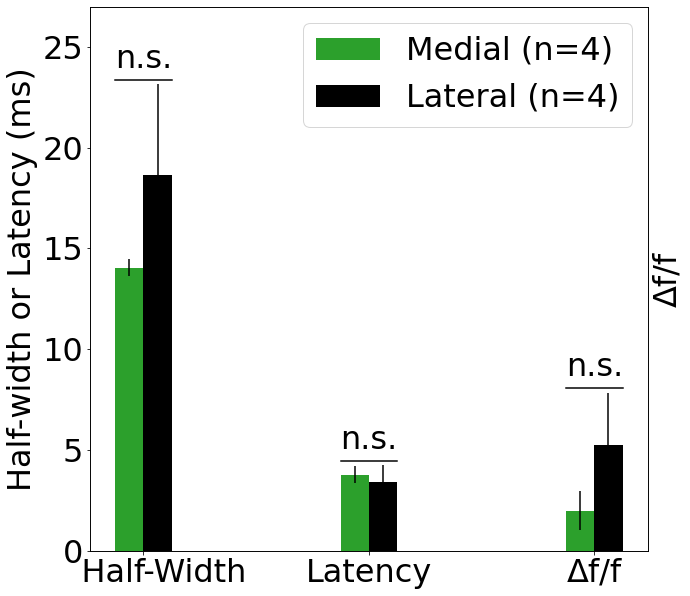

In [362]:
# using the 'Medial/Lateral' column in file export_summar_hw_latency_amp.csv, compare medial and lateral neighbor barrels
# for each layer and drug
# read in hw/lat/amp data
hw_lat_data = 'C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/' + 'export_summary_hw_latency_amp.csv'
hw_lat_df = pd.read_csv(hw_lat_data)
hw_lat_df['latency'] -= 48.6

# plot the data that has 'Medial/Lateral' column populated. Restrict to L4 and ACSF and neighbor barrels (ROI > 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot only for L4, not for L2/3. Compare latency, half-width, and amplitude for medial vs lateral neighbor barrels
directions = ['Medial', 'Lateral']
handles = []

for i, direction in enumerate(directions):
    color = 'tab:blue' if direction == 'Lateral' else 'tab:green'
    for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
        # get the data for the direction
        direction_df = hw_lat_df[(hw_lat_df['Layer'] == 'L4') & 
                                (hw_lat_df['drug'] == 'ACSF') & 
                                (hw_lat_df['ROI'] > 1) & 
                                (hw_lat_df['Medial/Lateral'] == direction)]
        # plot the data
        l1 = ax.bar(j + i / 8 - 1/16, 
                        np.mean(direction_df[metric]), 
                        yerr=sem(direction_df[metric]), 
                        width=.125,
                        color=color, label=direction)
        handles.append(l1)

# legend: Medial in black, Lateral in green
ax.legend(handles=[handles[0], handles[-1]], labels=['Medial (n=4)', 'Lateral (n=4)'], loc='upper right')

ax.set_ylabel('Half-width or Latency (ms)')
# right-side y-axis label
ax2 = ax.twinx()
ax2.set_ylabel('Δf/f')
ax2.set_yticks([])

ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['    Half-Width', 'Latency', 'Δf/f'])

# significance testing Medial vs Lateral
for j, metric in enumerate(['halfwidth', 'latency', 'amp']):
    med = hw_lat_df[(hw_lat_df['Layer'] == 'L4') & 
                                        (hw_lat_df['drug'] == 'ACSF') & 
                                        (hw_lat_df['ROI'] > 1) & 
                                        (hw_lat_df['Medial/Lateral'] == 'Medial')][metric]
    lat = hw_lat_df[(hw_lat_df['Layer'] == 'L4') &
                                        (hw_lat_df['drug'] == 'ACSF') &
                                        (hw_lat_df['ROI'] > 1) &
                                        (hw_lat_df['Medial/Lateral'] == 'Lateral')][metric]
    t_stat, p_val = ttest_ind(med, lat, equal_var=False)
    # draw bar between the two boxes # ax.get_ylim()[1] * 0.8
    height = max(med.mean() + sem(med), lat.mean() + sem(lat)) + 0.2

    ax.plot([j - 1/8, j + 1/8], [height, height], color='black')
    if p_val < 0.05:
        ax.text(j, height + .6, 'p < 0.05', ha='center')

        
    else:
        ax.text(j, height + .6, 'n.s.', ha='center')

# raise the y-axis limit by 10% to make room for the significance testing
ax.set_ylim(0, ax.get_ylim()[1] * 1.1)


plt.savefig('C:/Users/jjudge3/Desktop/Data/crossing_PPR/L23_vs_L4_NBQX/hw_lat_amp_medial_lateral.png')
plt.show()

## 